In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
from datetime import date, timedelta
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
import statsmodels.api as sm
from plotly.subplots import make_subplots
import itertools
import requests
import yfinance as yf
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import itertools
import pickle
import logging
import matplotlib.patches as mpatches
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from joblib import Memory
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import Ridge, Lasso
import sys
import os

import json
import traceback
from statsmodels.tools.sm_exceptions import ConvergenceWarning

from statsmodels.stats.diagnostic import acorr_ljungbox

from tqdm import tqdm
from arch import arch_model

import requests
import pandas as pd
import time

import pickle

import json
import traceback # Import traceback
from statsmodels.tools.sm_exceptions import ConvergenceWarning

from statsmodels.stats.diagnostic import acorr_ljungbox

from matplotlib.ticker import FuncFormatter

import matplotlib.ticker as mticker
from scipy.stats import norm


from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from fredapi import Fred

from datetime import datetime

In [2]:
# Définir la plage de dates
start_date = '2000-12-01'
end_date = datetime.today().strftime('%Y-%m-%d')

In [3]:
api_key = "8e877013bcb3862ac90cd864024bdb75"

def download_fred_data(series_id, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&observation_start={start_date}&observation_end={end_date}&file_type=json"
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data['observations'])
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.rename(columns={'value': series_id}, inplace=True)
    return df


# Base de donnée journaliére de base

def process_yield_data(data, column):
    # Conversion des valeurs en numériques, en gérant les erreurs
    data[column] = pd.to_numeric(data[column], errors='coerce')
    # Assurer que l'index est de type datetime
    data.index = pd.to_datetime(data.index)
    # Réinitialiser l'index et créer une nouvelle colonne 'Date' de type datetime
    data.reset_index(inplace=True)
    data['Date'] = pd.to_datetime(data['date'])  # Conversion directe en datetime
    # Supprimer la colonne 'date' d'origine
    data.drop(columns=['date'], inplace=True)
    # Supprimer les lignes contenant des valeurs manquantes
    data.dropna(inplace=True)
    return data[['Date', column]]


# Courbe des rendements à 2 ans
two_year_yield_curve_data = process_yield_data(download_fred_data("DGS2", "1900-01-01", "2025-12-31"), 'DGS2')
time.sleep(2)
# Courbe des rendements à 10 ans
ten_year_yield_curve_data = process_yield_data(download_fred_data("DGS10", "1900-01-01", "2025-12-31"), 'DGS10')
time.sleep(2)
# Courbe des rendements à 5 ans
five_year_yield_curve_data = process_yield_data(download_fred_data("DGS5", "1900-01-01", "2025-12-31"), 'DGS5')
time.sleep(2)
# Prix spot du pétrole brut West Texas Intermediate
DCOILWTICO_data = process_yield_data(download_fred_data("DCOILWTICO", "1900-01-01", "2025-12-31"), 'DCOILWTICO')
time.sleep(2)
# Indice de volatilité (VIX)
Volatility_Index = process_yield_data(download_fred_data("VIXCLS", "1900-01-01", "2025-12-31"), 'VIXCLS')



# Base de donnée mensuelle de base

# Fonction pour transformer les données mensuelles en données journalières
def process_data(data, column):
    data[column] = pd.to_numeric(data[column], errors='coerce')
    data.reset_index(inplace=True)
    # Créer une nouvelle colonne 'Date' avec le premier jour de chaque mois
    data['Date'] = pd.to_datetime(data['date'])
    # Répliquer les valeurs mensuelles pour chaque jour du mois
    daily_data = []
    for index, row in data.iterrows():
        # Créer une série de dates pour chaque mois, en répliquant la même valeur chaque jour
        month_days = pd.date_range(start=row['Date'], end=row['Date'].replace(day=1) + pd.offsets.MonthEnd(0), freq='D')
        daily_values = [row[column]] * len(month_days)  # Répéter la valeur du mois pour chaque jour
        daily_data.append(pd.DataFrame({column: daily_values, 'Date': month_days}))
    # Combiner tous les DataFrames journaliers en un seul DataFrame
    daily_data_df = pd.concat(daily_data, ignore_index=True)
    # Supprimer les lignes avec des valeurs manquantes
    daily_data_df.dropna(inplace=True)
    return daily_data_df[[column, 'Date']]


# Taux des fonds fédéraux
interest_rate_data = process_data(download_fred_data("FEDFUNDS", "1900-01-01", "2025-12-31"), 'FEDFUNDS')
time.sleep(2)
# Indice des prix à la consommation pour tous les consommateurs urbains
inflation_data = process_data(download_fred_data("CPIAUCNS", "1900-01-01", "2025-12-31"), 'CPIAUCNS')
time.sleep(2)
# Valeur des nouvelles commandes des fabricants pour toutes les industries manufacturières
industrial_orders_data = process_data(download_fred_data("AMTMNO", "1900-01-01", "2025-12-31"), 'AMTMNO')
time.sleep(2)
# Sentiment des consommateurs de l'Université du Michigan
consumer_sentiment_data = process_data(download_fred_data("UMCSENT", "1900-01-01", "2025-12-31"), 'UMCSENT')
time.sleep(2)
# Ventes au détail
retail_sales_data = process_data(download_fred_data("RSXFS", "1900-01-01", "2025-12-31"), 'RSXFS')
time.sleep(2)
# Taux de chômage
unemployment_rate_data = process_data(download_fred_data("UNRATE", "1900-01-01", "2025-12-31"), 'UNRATE')
time.sleep(2)
# Masse monétaire M2
M2_Money_Stock_data = process_data(download_fred_data("M2SL", "1900-01-01", "2025-12-31"), 'M2SL')
time.sleep(2)
# Indice des prix à la production pour toutes les marchandises
Producer_Price_Index = process_data(download_fred_data("PPIACO", "1900-01-01", "2025-12-31"), 'PPIACO')
time.sleep(2)
# Emploi total dans le secteur non agricole
Total_Nonfarm_Payroll = process_data(download_fred_data("PAYEMS", "1900-01-01", "2025-12-31"), 'PAYEMS')
time.sleep(2)
# Indice de la production industrielle
Industrial_Production_Index = process_data(download_fred_data("INDPRO", "1900-01-01", "2025-12-31"), 'INDPRO')
time.sleep(2)
# Pétrole brut
Crude_Petroleum = process_data(download_fred_data("WPU0561", "1900-01-01", "2025-12-31"), 'WPU0561')
time.sleep(2)
pce_data = process_data(download_fred_data("PCE", "1900-01-01", "2025-12-31"), 'PCE')
time.sleep(2)
# Indice de la production manufacturière
Manufacturing_Production_data = process_data(download_fred_data("IPMAN", "1900-01-01", "2025-12-31"), 'IPMAN')
time.sleep(2)
# Indice des prix des maisons
House_Price_Index_data = process_data(download_fred_data("CSUSHPISA", "1900-01-01", "2025-12-31"), 'CSUSHPISA')
time.sleep(2)
# Indice des prix des matières premières
Commodity_Price_Index_data = process_data(download_fred_data("PALLFNFINDEXM", "1900-01-01", "2025-12-31"), 'PALLFNFINDEXM')
time.sleep(2)
# Indice des conditions économiques de la Réserve fédérale de Chicago
Chicago_Fed_National_Activity_Index_data = process_data(download_fred_data("CFNAI", "1900-01-01", "2025-12-31"), 'CFNAI')
time.sleep(2)
# Débit personnel
Personal_Income_data = process_data(download_fred_data("PI", "1900-01-01", "2025-12-31"), 'PI')
time.sleep(2)
# Taux de participation à la population active
labor_force_participation_rate_data = process_data(download_fred_data("CIVPART", "1948-01-01", "2025-12-31"), 'CIVPART')
time.sleep(2)
# Balance commerciale
trade_balance_data = process_data(download_fred_data("BOPGSTB", "1960-01-01", "2025-12-31"), 'BOPGSTB')
time.sleep(2)
# Masse monétaire M1
M1_Money_Stock_data = process_data(download_fred_data("M1SL", "1959-01-01", "2025-12-31"), 'M1SL')
time.sleep(2)
# Prix du cuivre
Copper_Price_data = process_data(download_fred_data("PCOPPUSDM", "1983-01-01", "2025-12-31"), 'PCOPPUSDM')
time.sleep(2)
# Indice de production de biens durables
Durable_Goods_Production_Index_data = process_data(download_fred_data("IPDMAN", "1972-01-01", "2025-12-31"), 'IPDMAN')
time.sleep(2)
# Dépenses de consommation personnelle pour les services
PCE_Services_data = process_data(download_fred_data("PCES", "1959-01-01", "2025-12-31"), 'PCES')
time.sleep(2)
# Indice de production des biens de consommation
Consumer_Goods_Production_Index_data = process_data(download_fred_data("IPCONGD", "1972-01-01", "2025-12-31"), 'IPCONGD')
time.sleep(2)
# Indice de production des matériaux de construction
Construction_Materials_Production_Index_data = process_data(download_fred_data("IPB51220N", "1972-01-01", "2025-12-31"), 'IPB51220N')
time.sleep(2)
# CPI pour l'inflation générale (CPIAUCSL)
CPIAUCSL_data = process_data(download_fred_data("CPIAUCSL", "1900-01-01", "2025-12-31"), 'CPIAUCSL')
time.sleep(2)
# CPI pour l'inflation sous-jacente (CPILFESL)
CPILFESL_data = process_data(download_fred_data("CPILFESL", "1900-01-01", "2025-12-31"), 'CPILFESL')



# Fonction pour transformer les données trimestrielles en données journalières
def process_quarterly_data(data, column):
    data[column] = pd.to_numeric(data[column], errors='coerce')
    data.reset_index(inplace=True)
    # Créer une nouvelle colonne 'Date' avec la date du premier jour de chaque trimestre
    data['Date'] = pd.to_datetime(data['date'])
    # Répliquer les valeurs trimestrielles pour chaque jour du trimestre
    daily_data = []
    for index, row in data.iterrows():
        # Créer une série de dates pour chaque trimestre
        quarter_end = row['Date'] + pd.offsets.QuarterEnd(0)
        quarter_days = pd.date_range(start=row['Date'], end=quarter_end, freq='D')
        daily_values = [row[column]] * len(quarter_days)  # Répéter la valeur du trimestre pour chaque jour
        daily_data.append(pd.DataFrame({column: daily_values, 'Date': quarter_days}))
    # Combiner tous les DataFrames journaliers en un seul DataFrame
    daily_data_df = pd.concat(daily_data, ignore_index=True)
    # Supprimer les lignes avec des valeurs manquantes
    daily_data_df.dropna(inplace=True)
    return daily_data_df[[column, 'Date']]


# Formation brute de capital fixe
investment_data = process_quarterly_data(download_fred_data("GPDIC1", "1900-01-01", "2024-12-31"), 'GPDIC1')
time.sleep(2)
# Produit intérieur brut (PIB)
gdp_data = process_quarterly_data(download_fred_data("GDP", "1900-01-01", "2024-12-31"), 'GDP')
time.sleep(2)
# Balance commerciale des États-Unis
balance_commerciale = process_quarterly_data(download_fred_data("NETEXP", "1900-01-01", "2024-12-31"), 'NETEXP')
time.sleep(2)
# Déficit budgétaire des États-Unis
déficit_budgétaire = process_quarterly_data(download_fred_data("GFDEBTN", "1900-01-01", "2024-12-31"), 'GFDEBTN')


In [4]:

# Définir les paires de devises
currency_pairs = ['GBPUSD=X','EURUSD=X', 'EURGBP=X', 'EURJPY=X', 'EURCAD=X', 'GBPNZD=X', 'CNYUSD=X', 'CNYEUR=X', 'GBPCNY=X', 'EURCHF=X', 'CHFUSD=X', 'GC=F','DX-Y.NYB','^IRX','^TNX','USDJPY=X','EEM','TLT','^GSPC','GC=F','USDCHF=X','^DJI','EURNOK=X','CL=F']

# Créer une liste vide pour stocker les DataFrames
currency_data_list = []

# Télécharger les données pour chaque paire de devises
for currency_pair in currency_pairs:
    # Télécharger les données pour la paire de devises
    currency_data = yf.download(currency_pair, start=start_date)
    # Extraire la colonne 'Close' pour le taux de change et ajouter la colonne 'Date'
    currency_data = currency_data[['Close']].reset_index()
    # Reformater le nom de la devise sous la forme EUR/JPY
    currency_name = currency_pair.split('=')[0]
    formatted_currency_name = currency_name[:3] + '/' + currency_name[3:]  # Convertit EURJPY en EUR/JPY
    # Renommer la colonne pour correspondre à la devise choisie
    currency_data.columns = ['Date', formatted_currency_name]
    # Convertir la colonne 'Date' en datetime
    currency_data['Date'] = pd.to_datetime(currency_data['Date'])
    # Ajouter le DataFrame à la liste
    currency_data_list.append(currency_data)

# Fusionner tous les DataFrames sur la colonne 'Date'
final_currency_data = currency_data_list[0]

for data in currency_data_list[1:]:
    final_currency_data = pd.merge(final_currency_data, data, on='Date', how='outer')

# Afficher le tableau final
final_currency_data.dropna(inplace=True)

# Réinitialiser l'index
final_currency_data = final_currency_data.reset_index(drop=True)

final_currency_data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Date   GBP/USD   EUR/USD  EUR/GBP     EUR/JPY  EUR/CAD  GBP/NZD  \
0    2003-12-01  1.718597  1.196501  0.69570  130.580002  1.55960  2.67300   
1    2003-12-02  1.730313  1.208897  0.69800  131.440002  1.56700  2.67540   
2    2003-12-03  1.728101  1.212298  0.70070  131.259995  1.57590  2.67340   
3    2003-12-04  1.720697  1.208094  0.70180  130.759995  1.58290  2.66510   
4    2003-12-05  1.733102  1.218695  0.70300  130.729996  1.58760  2.68170   
...         ...       ...       ...      ...         ...      ...      ...   
5425 2025-09-22  1.346475  1.173695  0.87165  173.811996  1.61761  2.30095   
5426 2025-09-23  1.351497  1.180108  0.87310  174.328995  1.63138  2.30251   
5427 2025-09-24  1.352448  1.181447  0.87359  174.382004  1.63479  2.30887   
5428 2025-09-25  1.345240  1.174467  0.87300  174.695999  1.63191  2.31248   
5429 2025-09-26  1.340195  1.170823  0.87309  174.959000  1.62583  2.32148   

       CNY/USD   CNY/EUR    GBP/CNY  ...  ^TN/X     USD/JPY       EEM/  \
0     0.120960  0.100850  14.185000  ...  4.392  109.169998  11.303282   
1     0.120960  0.099770  14.283000  ...  4.380  108.730003  11.253134   
2     0.120961  0.099700  14.257000  ...  4.410  108.300003  11.213890   
3     0.120963  0.099870  14.205000  ...  4.369  108.269997  11.136852   
4     0.120964  0.099180  14.279000  ...  4.215  107.620003  11.115774   
...        ...       ...        ...  ...    ...         ...        ...   
5425  0.140590  0.119764   9.577342  ...  4.143  148.095001  53.270000   
5426  0.140568  0.119101   9.614033  ...  4.120  147.725006  53.299999   
5427  0.140615  0.119008   9.616508  ...  4.147  147.613007  53.119999   
5428  0.140223  0.119364   9.593829  ...  4.172  148.751007  52.810001   
5429  0.140178  0.119770   9.559600  ...  4.187  149.453995  52.709999   

           TLT/       ^GS/PC        GC/_y  USD/CHF         ^DJ/I   EUR/NOK  \
0     41.180084  1070.119995   402.700012  1.29810   9899.049805   8.16400   
1     41.356075  1066.619995   403.700012  1.28720   9853.639648   8.16350   
2     41.189892  1064.729980   403.899994  1.28520   9873.419922   8.11800   
3     41.282734  1069.719971   403.299988  1.28850   9930.820312   8.08380   
4     41.942715  1061.500000   406.399994  1.27240   9862.679688   8.08250   
...         ...          ...          ...      ...           ...       ...   
5425  88.699997  6693.750000  3740.699951  0.79623  46381.539062  11.64479   
5426  89.320000  6656.919922  3780.600098  0.79239  46292.781250  11.69616   
5427  88.980003  6637.970215  3732.100098  0.79143  46121.281250  11.67357   
5428  88.980003  6604.720215  3736.899902  0.79466  45947.320312  11.66958   
5429  88.900002  6643.700195  3809.000000  0.80004  46247.289062  11.67145   

            CL/  
0     29.950001  
1     30.780001  
2     31.100000  
3     31.260000  
4     30.730000  
...         ...  
5425  62.639999  
5426  63.410000  
5427  64.989998  
5428  64.980003  
5429  65.720001  

[5430 rows x 25 columns]

In [5]:
# Demander à l'utilisateur de saisir la paire de devises
chosen_currency = input("Veuillez entrer la paire de devises (par exemple, EUR/USD) : ")

In [6]:
base, quote = chosen_currency.split("/")
currency_pair = f"{base}{quote}=X"

# Télécharger les données complètes (OHLC)
data = yf.download(currency_pair, start=start_date, end=end_date)

# Extraire la colonne 'Close'
currency_data = data[['Close']].reset_index()
currency_data.columns = ['Date', chosen_currency]

# Nettoyage final
currency_data = currency_data.dropna().reset_index(drop=True)
currency_data

[*********************100%***********************]  1 of 1 completed


Date   EUR/USD
0    2003-12-01  1.196501
1    2003-12-02  1.208897
2    2003-12-03  1.212298
3    2003-12-04  1.208094
4    2003-12-05  1.218695
...         ...       ...
5658 2025-09-22  1.173695
5659 2025-09-23  1.180108
5660 2025-09-24  1.181447
5661 2025-09-25  1.174467
5662 2025-09-26  1.170823

[5663 rows x 2 columns]

In [7]:

# Liste des ensembles de données avec leurs noms
datasets = [
    "two_year_yield_curve_data",
    "ten_year_yield_curve_data",
    "inflation_data",
    "DCOILWTICO_data",
    "investment_data",
    "gdp_data",
    "consumer_sentiment_data",
    "retail_sales_data",
    "interest_rate_data",
    "five_year_yield_curve_data",
    "unemployment_rate_data",
    "M2_Money_Stock_data",
    "Producer_Price_Index",
    "Total_Nonfarm_Payroll",
    "Volatility_Index",
    "Industrial_Production_Index",
    "Crude_Petroleum",
    "pce_data",
    "Personal_Income_data",
    "Chicago_Fed_National_Activity_Index_data",
    "Commodity_Price_Index_data",
    "House_Price_Index_data",
    "Manufacturing_Production_data",
    "labor_force_participation_rate_data",
    "trade_balance_data",
    "M1_Money_Stock_data",
    "Durable_Goods_Production_Index_data",
    "Copper_Price_data",
    "PCE_Services_data",
    "Consumer_Goods_Production_Index_data",
    "Construction_Materials_Production_Index_data",
    "balance_commerciale",
    "déficit_budgétaire",
    "CPIAUCSL_data",
    "CPILFESL_data",
    "final_currency_data",
    "currency_data"
]

# Charger le premier ensemble de données
pmi_data = globals()[datasets[0]]

# Fusionner avec les autres ensembles de données
for data_name in datasets[1:]:
    data = globals()[data_name]
    pmi_data = pd.merge(pmi_data, data, on='Date', how='outer', suffixes=('', '_dup'))

    # Supprimer les colonnes en double (celles dont le suffixe est '_dup')
    columns_to_drop = [col for col in pmi_data.columns if col.endswith('_dup')]
    pmi_data.drop(columns=columns_to_drop, inplace=True)

# Affichage du DataFrame combiné
pmi_data.dropna(inplace=True)
pmi_data.reset_index(drop=True, inplace=True)
pmi_data


Date  DGS2  DGS10  CPIAUCNS  DCOILWTICO    GPDIC1        GDP  \
0    2003-12-01  2.12   4.40   184.300       29.89  2493.928  11772.234   
1    2003-12-02  2.07   4.38   184.300       30.74  2493.928  11772.234   
2    2003-12-03  2.09   4.41   184.300       30.61  2493.928  11772.234   
3    2003-12-04  2.06   4.38   184.300       31.24  2493.928  11772.234   
4    2003-12-05  1.88   4.23   184.300       30.68  2493.928  11772.234   
...         ...   ...    ...       ...         ...       ...        ...   
5201 2024-12-24  4.29   4.59   315.605       70.87  4315.564  29825.182   
5202 2024-12-26  4.30   4.58   315.605       70.38  4315.564  29825.182   
5203 2024-12-27  4.31   4.62   315.605       71.28  4315.564  29825.182   
5204 2024-12-30  4.24   4.55   315.605       71.73  4315.564  29825.182   
5205 2024-12-31  4.25   4.58   315.605       72.44  4315.564  29825.182   

      UMCSENT     RSXFS  FEDFUNDS  ...  ^TN/X     USD/JPY       EEM/  \
0        92.6  271550.0      0.98  ...  4.392  109.169998  11.303282   
1        92.6  271550.0      0.98  ...  4.380  108.730003  11.253134   
2        92.6  271550.0      0.98  ...  4.410  108.300003  11.213890   
3        92.6  271550.0      0.98  ...  4.369  108.269997  11.136852   
4        92.6  271550.0      0.98  ...  4.215  107.620003  11.115774   
...       ...       ...       ...  ...    ...         ...        ...   
5201     74.0  622396.0      4.48  ...  4.591  157.164993  42.230888   
5202     74.0  622396.0      4.48  ...  4.579  157.132996  42.082329   
5203     74.0  622396.0      4.48  ...  4.619  157.748001  41.894150   
5204     74.0  622396.0      4.48  ...  4.545  157.873001  41.557411   
5205     74.0  622396.0      4.48  ...  4.573  156.994995  41.418755   

           TLT/       ^GS/PC        GC/_y  USD/CHF         ^DJ/I   EUR/NOK  \
0     41.180084  1070.119995   402.700012  1.29810   9899.049805   8.16400   
1     41.356075  1066.619995   403.700012  1.28720   9853.639648   8.16350   
2     41.189892  1064.729980   403.899994  1.28520   9873.419922   8.11800   
3     41.282734  1069.719971   403.299988  1.28850   9930.820312   8.08380   
4     41.942715  1061.500000   406.399994  1.27240   9862.679688   8.08250   
...         ...          ...          ...      ...           ...       ...   
5201  85.357193  6040.040039  2620.000000  0.89847  43297.031250  11.81031   
5202  85.308617  6037.589844  2638.800049  0.89942  43325.800781  11.77991   
5203  84.609207  5970.839844  2617.199951  0.89890  42992.210938  11.87089   
5204  85.289185  5906.939941  2606.100098  0.90184  42573.730469  11.83283   
5205  84.832642  5881.629883  2629.199951  0.90324  42544.218750  11.78811   

            CL/  
0     29.950001  
1     30.780001  
2     31.100000  
3     31.260000  
4     30.730000  
...         ...  
5201  70.099998  
5202  69.620003  
5203  70.599998  
5204  70.989998  
5205  71.720001  

[5206 rows x 60 columns]

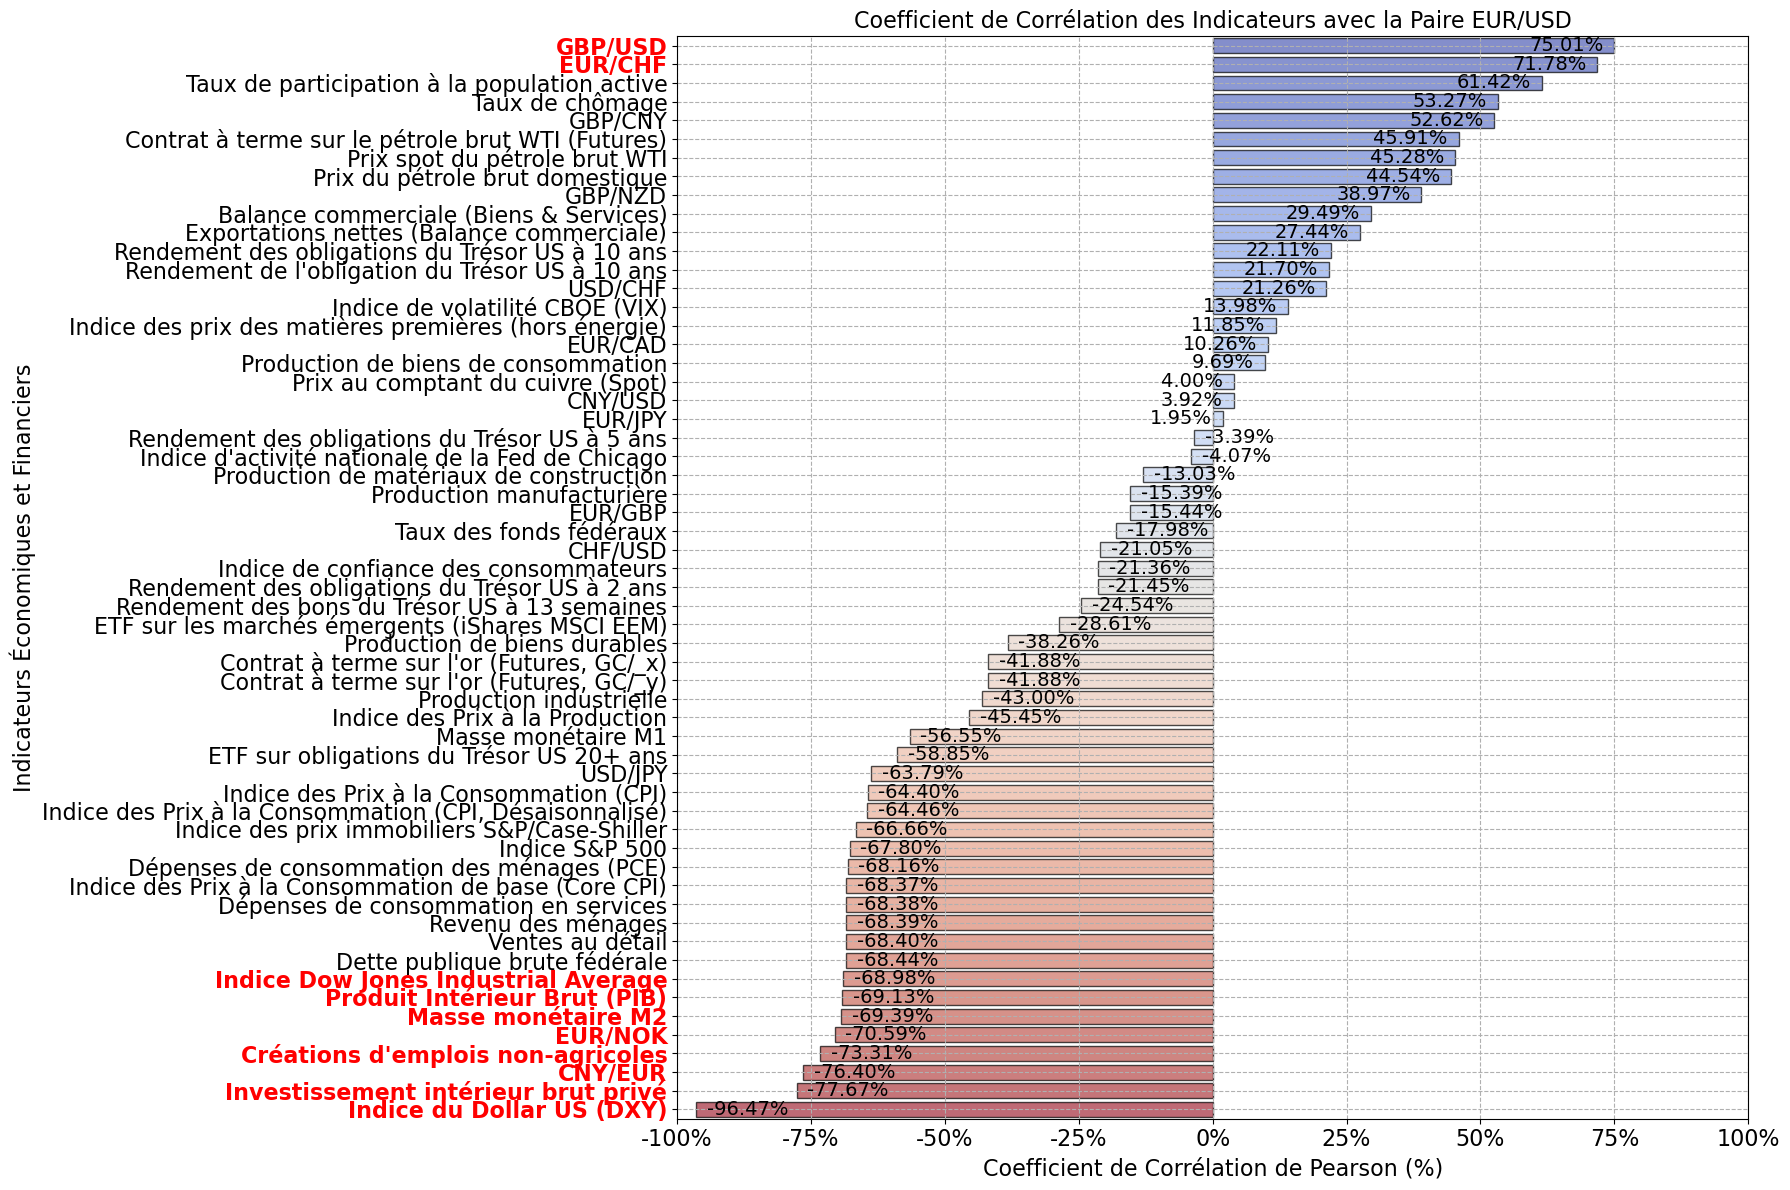

In [8]:

# ==============================================================================
# 1. DICTIONNAIRE DE TRADUCTION (Labels professionnels pour une thèse)
# ==============================================================================
ticker_to_name_map = {
    # === Taux d'intérêt et Obligations ===
    # "Rendement" est plus précis que "Taux" pour les obligations sur le marché secondaire.
    'DGS2': "Rendement des obligations du Trésor US à 2 ans",
    'DGS5': "Rendement des obligations du Trésor US à 5 ans",
    'DGS10': "Rendement des obligations du Trésor US à 10 ans",
    'FEDFUNDS': "Taux des fonds fédéraux",
    '^IR/X': "Rendement des bons du Trésor US à 13 semaines", # "Bons du Trésor" (T-Bills) est le terme pour le court terme.
    '^TN/X': "Rendement de l'obligation du Trésor US à 10 ans",
    'TLT/': "ETF sur obligations du Trésor US 20+ ans", # Préciser l'émetteur est un plus.

    # === Inflation et Prix ===
    # "Désaisonnalisé" clarifie la nature de la donnée.
    'CPIAUCNS': "Indice des Prix à la Consommation (CPI)",
    'CPIAUCSL': "Indice des Prix à la Consommation (CPI, Désaisonnalisé)",
    'CPILFESL': "Indice des Prix à la Consommation de base (Core CPI)", # "de base" est la traduction de "Core".
    'PCE': "Dépenses de consommation des ménages (PCE)", # "Ménages" est plus standard que "Personnelle".
    'PPIACO': "Indice des Prix à la Production",
    'CSUSHPISA': "Indice des prix immobiliers S&P/Case-Shiller",
    'PALLFNFINDEXM': "Indice des prix des matières premières (hors énergie)",
    'PCOPPUSDM': "Prix au comptant du cuivre (Spot)", # "Spot" ou "au comptant" est plus précis.

    # === Économie et Emploi ===
    # Les termes étaient déjà bons, légères clarifications.
    'GDP': "Produit Intérieur Brut (PIB)",
    'UNRATE': "Taux de chômage",
    'PAYEMS': "Créations d'emplois non-agricoles",
    'INDPRO': "Production industrielle",
    'IPMAN': "Production manufacturière",
    'CFNAI': "Indice d'activité nationale de la Fed de Chicago",
    'GPDIC1': "Investissement intérieur brut privé",
    'CIVPART': "Taux de participation à la population active",
    'IPDMAN': "Production de biens durables",
    'IPCONGD': "Production de biens de consommation",
    'IPB51220N': "Production de matériaux de construction",
    'BOPGSTB': "Balance commerciale (Biens & Services)",
    'NETEXP': "Exportations nettes (Balance commerciale)",
    'GFDEBTN': "Dette publique brute fédérale",

    # === Consommation et Revenus ===
    'UMCSENT': "Indice de confiance des consommateurs",
    'RSXFS': "Ventes au détail",
    'PI': "Revenu des ménages",
    'PCES': "Dépenses de consommation en services",

    # === Masse Monétaire ===
    # "Agrégat" est le terme technique formel.
    'M1SL': "Masse monétaire M1",
    'M2SL': "Masse monétaire M2",

    # === Matières Premières et Volatilité ===
    # Distinction claire entre prix spot (physique) et contrats à terme (financiers).
    'DCOILWTICO': "Prix spot du pétrole brut WTI",
    'WPU0561': "Prix du pétrole brut domestique", # IPP = Indice des Prix à la Production
    'VIXCLS': "Indice de volatilité CBOE (VIX)",
    'CL/': "Contrat à terme sur le pétrole brut WTI (Futures)",
    'GC/_x': "Contrat à terme sur l'or (Futures, GC/_x)",
    'GC/_y': "Contrat à terme sur l'or (Futures, GC/_y)",

    # === Indices Boursiers ===
    # Utilisation des noms complets et reconnus.
    '^GS/PC': "Indice S&P 500", # Le ticker est un détail technique, le nom de l'indice suffit.
    '^DJ/I': "Indice Dow Jones Industrial Average",

    # === Paires de Devises ===
    # Le format standard est déjà parfait.
    'EUR/USD': 'EUR/USD', 'GBP/USD': 'GBP/USD', 'USD/JPY': "USD/JPY", 'EUR/GBP': "EUR/GBP",
    'EUR/JPY': "EUR/JPY", 'EUR/CAD': "EUR/CAD", 'GBP/NZD': "GBP/NZD", 'CNY/USD': "CNY/USD",
    'CNY/EUR': "CNY/EUR", 'EUR/CHF': 'EUR/CHF', 'CHF/USD': "CHF/USD", 'EUR/NOK': "EUR/NOK",
    'GBP/CNY': "GBP/CNY", 'USD/CHF': "USD/CHF",

    # === Indice Dollar et autres ===
    'DX-/Y.NYB': "Indice du Dollar US (DXY)",
    'EEM/': "ETF sur les marchés émergents (iShares MSCI EEM)", # Préciser l'indice sous-jacent (MSCI) est un plus.
}

# ==============================================================================
# 2. CODE DE CALCUL ET DE GÉNÉRATION DU GRAPHIQUE (VOTRE CODE ORIGINAL)
# ==============================================================================

# Assurez-vous que vos données `pmi_data` et votre variable `chosen_currency` sont bien définies avant ce bloc
if chosen_currency in pmi_data.columns:
    numeric_columns = pmi_data.select_dtypes(include='number')
    correlation_matrix = numeric_columns.corrwith(pmi_data[chosen_currency])
    correlation_matrix.drop(chosen_currency, inplace=True, errors='ignore')

    # Obtenir les 10 tickers les plus corrélés (en valeur absolue)
    top_10_correlations = correlation_matrix.abs().nlargest(10)
    top_3_indices = top_10_correlations.index

    # Trier la matrice pour l'affichage
    correlation_matrix.sort_values(ascending=False, inplace=True)

    # --- Création du graphique ---
    plt.figure(figsize=(18, 12))

    # ÉTAPE 1 : On crée le barplot SANS renommer les labels. L'axe Y utilise les tickers originaux.
    ax = sns.barplot(y=correlation_matrix.index, x=correlation_matrix.values, palette='coolwarm', edgecolor='black', alpha=0.7, orient='h')

    # Titres et axes
    plt.title(f'Coefficient de Corrélation des Indicateurs avec la Paire {chosen_currency}', fontsize=16)
    plt.xlabel('Coefficient de Corrélation de Pearson (%)', fontsize=16)
    plt.ylabel('Indicateurs Économiques et Financiers', fontsize=16)
    plt.xticks(rotation=0, ha='center', fontsize=16)
    plt.yticks(rotation=0, fontsize=16)
    plt.grid(axis='x', linestyle='--', alpha=1)
    plt.grid(axis='y', linestyle='--', alpha=1)
    plt.xlim(-1, 1)

    # ÉTAPE 2 : On colore les labels. La comparaison est maintenant DIRECTE et INFAILLIBLE.
    for label in ax.get_yticklabels():
        if label.get_text() in top_3_indices:
            label.set_color('red')
            label.set_weight('bold')

    # ÉTAPE 3 : SEULEMENT MAINTENANT, on traduit les labels pour l'affichage final.
    new_labels = [ticker_to_name_map.get(label.get_text(), label.get_text()) for label in ax.get_yticklabels()]
    ax.set_yticklabels(new_labels)

    # Formater les étiquettes de l'axe x en pourcentage
    xlabels = [f'{x*100:.0f}%' for x in ax.get_xticks()]
    ax.set_xticklabels(xlabels)

    # Placer les valeurs de corrélation
    for i, (ticker, value) in enumerate(correlation_matrix.items()):
        if value >= 0:
            plt.text(value - 0.02, i, f'{value*100:.2f}%', ha='right', va='center', fontsize=14, color='black')
        else:
            plt.text(value + 0.02, i, f'{value*100:.2f}%', ha='left', va='center', fontsize=14, color='black')

    plt.tight_layout()
    plt.show()

else:
    print(f"La colonne '{chosen_currency}' n'existe pas dans les données.")

In [9]:
first_indicator = top_3_indices[0]
second_indicator = top_3_indices[1]
third_indicator = top_3_indices[2]
fourth_indicator = top_3_indices[3]
fifth_indicator = top_3_indices[4]
sixth_indicator = top_3_indices[5]
seventh_indicator = top_3_indices[6]
eighth_indicator = top_3_indices[7]
ninth_indicator = top_3_indices[8]
tenth_indicator = top_3_indices[9]

# Liste des colonnes que vous voulez garder
colonnes_a_garder = [chosen_currency, first_indicator, second_indicator, third_indicator,
                    fourth_indicator, fifth_indicator, sixth_indicator, seventh_indicator,
                    eighth_indicator, ninth_indicator, tenth_indicator, 'Date']

# Supprimer les colonnes non nécessaires
pmi_data = pmi_data[colonnes_a_garder]

# Filtrer les données jusqu'au 25 novembre 2024
# pmi_data = pmi_data[pmi_data['Date'] <= '2024-07-28']

cm = sns.light_palette('green', as_cmap=True)
pmi_data.head(10).style.background_gradient(cmap=cm)

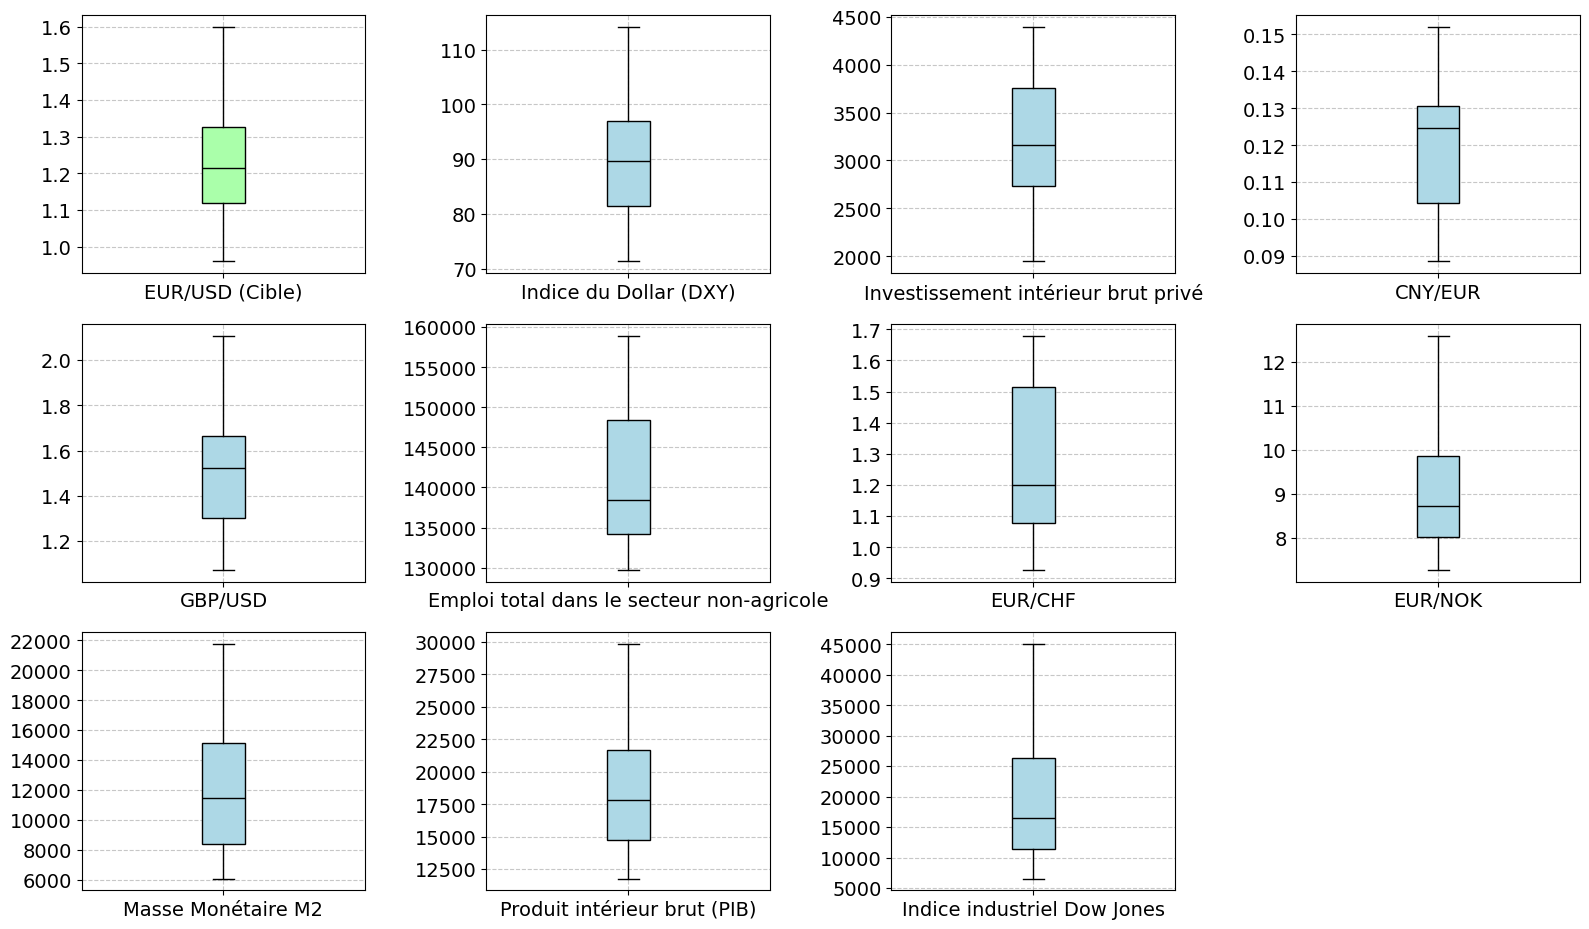

In [10]:

# --- Paramètres de style ---
box_outline_color = 'black'
box_fill_color = '#ADD8E6'  # Couleur standard pour tous sauf EUR/USD
eurusd_color = '#aaffaa'    # Couleur spécifique pour EUR/USD
median_line_color = 'black'
outlier_marker_size = 1.0
axis_font_size = 14
grid_style = '--'
grid_alpha = 0.7

# --- Création de la figure ---
plt.figure(figsize=(16, 10))

# Liste des variables et titres associés
variables = [
    ('EUR/USD', 'EUR/USD (Cible)'),
    ('DX-/Y.NYB', 'Indice du Dollar (DXY)'),
    ('GPDIC1', 'Investissement intérieur brut privé'),
    ('CNY/EUR', 'CNY/EUR'),
    ('GBP/USD', 'GBP/USD'),
    ('PAYEMS', 'Emploi total dans le secteur non-agricole'),
    ('EUR/CHF', 'EUR/CHF'),
    ('EUR/NOK', 'EUR/NOK'),
    ('M2SL', 'Masse Monétaire M2'),
    ('GDP', 'Produit intérieur brut (PIB)'),
    ('^DJ/I', 'Indice industriel Dow Jones')
]

# Création des sous-graphiques
for i, (col, title) in enumerate(variables):
    plt.subplot(3, 4, i + 1)

    # Choix de la couleur spécifique pour EUR/USD
    face_color = eurusd_color if col == 'EUR/USD' else box_fill_color

    plt.boxplot(pmi_data[col], patch_artist=True,
                boxprops=dict(color=box_outline_color, facecolor=face_color),
                medianprops=dict(color=median_line_color),
                flierprops=dict(marker='o', markersize=outlier_marker_size))
    plt.xticks([1], [title], fontsize=axis_font_size, rotation=0, ha='center')
    plt.yticks(fontsize=axis_font_size)
    plt.grid(True, linestyle=grid_style, alpha=grid_alpha)

# Cas où on a que 11 variables, on cache le 12ème plot
if len(variables) < 12:
    plt.subplot(3, 4, 12)
    plt.axis('off')

# Ajustement layout
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


In [11]:

pmi_data.interpolate(method='linear', inplace=True)

# Créer une liste de toutes les colonnes sauf "Date"
columns_to_normalize = [chosen_currency, first_indicator, second_indicator, third_indicator,
                    fourth_indicator, fifth_indicator, sixth_indicator, seventh_indicator,
                    eighth_indicator, ninth_indicator, tenth_indicator]

# Initialiser le scaler
scaler = StandardScaler()

# Normaliser les colonnes sélectionnées
pmi_data[columns_to_normalize] = scaler.fit_transform(pmi_data[columns_to_normalize])
pmi_data

EUR/USD  DX-/Y.NYB    GPDIC1   CNY/EUR   GBP/USD    PAYEMS   EUR/CHF  \
0    -0.255382   0.069667 -1.063309 -1.206983  0.806060 -1.275504  1.358445   
1    -0.158678  -0.006614 -1.063309 -1.276663  0.855044 -1.275504  1.375093   
2    -0.132154  -0.021655 -1.063309 -1.281179  0.845792 -1.275504  1.382742   
3    -0.164944  -0.010912 -1.063309 -1.270211  0.814838 -1.275504  1.374193   
4    -0.082249  -0.060333 -1.063309 -1.314728  0.866703 -1.275504  1.348997   
...        ...        ...       ...       ...       ...       ...       ...   
5201 -1.471720   1.993884  1.698008  0.781718 -1.138623  2.098222 -1.420548   
5202 -1.476616   1.979917  1.698008  0.786428 -1.134745  2.098222 -1.418793   
5203 -1.458182   1.965950  1.698008  0.767524 -1.140593  2.098222 -1.411684   
5204 -1.453348   1.979917  1.698008  0.761394 -1.120087  2.098222 -1.395081   
5205 -1.471466   2.018594  1.698008  0.779717 -1.132507  2.098222 -1.397871   

       EUR/NOK      M2SL       GDP     ^DJ/I       Date  
0    -0.719419 -1.272944 -1.432738 -1.020800 2003-12-01  
1    -0.719827 -1.272944 -1.432738 -1.025611 2003-12-02  
2    -0.756963 -1.272944 -1.432738 -1.023515 2003-12-03  
3    -0.784877 -1.272944 -1.432738 -1.017434 2003-12-04  
4    -0.785938 -1.272944 -1.432738 -1.024653 2003-12-05  
...        ...       ...       ...       ...        ...  
5201  2.256630  1.764934  2.333490  2.517862 2024-12-24  
5202  2.231818  1.764934  2.333490  2.520910 2024-12-26  
5203  2.306074  1.764934  2.333490  2.485565 2024-12-27  
5204  2.275011  1.764934  2.333490  2.441225 2024-12-30  
5205  2.238511  1.764934  2.333490  2.438098 2024-12-31  

[5206 rows x 12 columns]

In [12]:

def prepare_data(data, look_back=6):
    X_retail_sales = []
    X_Inflation = []
    X_GDP = []
    X_GPDIC1 = []
    X_indicator4 = []
    X_indicator5 = []
    X_indicator6 = []
    X_indicator7 = []
    X_indicator8 = []
    X_indicator9 = []
    X_indicator10 = []

    y_retail_sales = []
    y_Inflation = []
    y_GDP = []
    y_GPDIC1 = []
    y_indicator4 = []
    y_indicator5 = []
    y_indicator6 = []
    y_indicator7 = []
    y_indicator8 = []
    y_indicator9 = []
    y_indicator10 = []

    for i in range(len(data) - look_back):
        X_row_retail_sales = []
        X_row_Inflation = []
        X_row_GDP = []
        X_row_GPDIC1 = []
        X_row_indicator4 = []
        X_row_indicator5 = []
        X_row_indicator6 = []
        X_row_indicator7 = []
        X_row_indicator8 = []
        X_row_indicator9 = []
        X_row_indicator10 = []

        for column in [chosen_currency, first_indicator, second_indicator, third_indicator,
                      fourth_indicator, fifth_indicator, sixth_indicator, seventh_indicator,
                      eighth_indicator, ninth_indicator, tenth_indicator]:
            if column == chosen_currency:
                X_row_retail_sales.extend(data[column].iloc[i:i+look_back].values.flatten())
            elif column == first_indicator:
                X_row_Inflation.extend(data[column].iloc[i:i+look_back].values.flatten())
            elif column == second_indicator:
                X_row_GDP.extend(data[column].iloc[i:i+look_back].values.flatten())
            elif column == third_indicator:
                X_row_GPDIC1.extend(data[column].iloc[i:i+look_back].values.flatten())
            elif column == fourth_indicator:
                X_row_indicator4.extend(data[column].iloc[i:i+look_back].values.flatten())
            elif column == fifth_indicator:
                X_row_indicator5.extend(data[column].iloc[i:i+look_back].values.flatten())
            elif column == sixth_indicator:
                X_row_indicator6.extend(data[column].iloc[i:i+look_back].values.flatten())
            elif column == seventh_indicator:
                X_row_indicator7.extend(data[column].iloc[i:i+look_back].values.flatten())
            elif column == eighth_indicator:
                X_row_indicator8.extend(data[column].iloc[i:i+look_back].values.flatten())
            elif column == ninth_indicator:
                X_row_indicator9.extend(data[column].iloc[i:i+look_back].values.flatten())
            elif column == tenth_indicator:
                X_row_indicator10.extend(data[column].iloc[i:i+look_back].values.flatten())

        X_retail_sales.append(X_row_retail_sales)
        X_Inflation.append(X_row_Inflation)
        X_GDP.append(X_row_GDP)
        X_GPDIC1.append(X_row_GPDIC1)
        X_indicator4.append(X_row_indicator4)
        X_indicator5.append(X_row_indicator5)
        X_indicator6.append(X_row_indicator6)
        X_indicator7.append(X_row_indicator7)
        X_indicator8.append(X_row_indicator8)
        X_indicator9.append(X_row_indicator9)
        X_indicator10.append(X_row_indicator10)

        y_retail_sales.append(data[chosen_currency].iloc[i+look_back])
        y_Inflation.append(data[first_indicator].iloc[i+look_back])
        y_GDP.append(data[second_indicator].iloc[i+look_back])
        y_GPDIC1.append(data[third_indicator].iloc[i+look_back])
        y_indicator4.append(data[fourth_indicator].iloc[i+look_back])
        y_indicator5.append(data[fifth_indicator].iloc[i+look_back])
        y_indicator6.append(data[sixth_indicator].iloc[i+look_back])
        y_indicator7.append(data[seventh_indicator].iloc[i+look_back])
        y_indicator8.append(data[eighth_indicator].iloc[i+look_back])
        y_indicator9.append(data[ninth_indicator].iloc[i+look_back])
        y_indicator10.append(data[tenth_indicator].iloc[i+look_back])

    return (
        np.array(X_retail_sales),
        np.array(X_Inflation),
        np.array(X_GDP),
        np.array(X_GPDIC1),
        np.array(X_indicator4),
        np.array(X_indicator5),
        np.array(X_indicator6),
        np.array(X_indicator7),
        np.array(X_indicator8),
        np.array(X_indicator9),
        np.array(X_indicator10),
        np.array(y_retail_sales),
        np.array(y_Inflation),
        np.array(y_GDP),
        np.array(y_GPDIC1),
        np.array(y_indicator4),
        np.array(y_indicator5),
        np.array(y_indicator6),
        np.array(y_indicator7),
        np.array(y_indicator8),
        np.array(y_indicator9),
        np.array(y_indicator10)
    )


In [13]:

#Définition des pourcentages de fractionnement
split_percentages = range(1, 10)

# Dictionnaire pour stocker les proportions et les tailles correspondantes des ensembles d'entraînement et de test
split_sizes = {}

best_score = float('inf')
best_split = None

errors = []

for percentage in split_percentages:
    # Convertir le pourcentage en proportion
    percentage /= 10.0

    # Séparation des données en fonction de l'index pour l'entraînement et le test
    train_data, test_data = train_test_split(pmi_data, train_size = percentage, shuffle=False)

    # Stocker les tailles des ensembles d'entraînement et de test
    train_size = len(train_data)
    test_size = len(test_data)
    split_sizes[percentage] = {'train_size': train_size, 'test_size': test_size}

    # Préparation des données d'entraînement et de test
    (X_train_retail_sales, X_train_Inflation, X_train_GDP, X_train_GPDIC1,
     X_train_indicator4, X_train_indicator5, X_train_indicator6, X_train_indicator7,
     X_train_indicator8, X_train_indicator9, X_train_indicator10,
     y_train_retail_sales, y_train_Inflation, y_train_GDP, y_train_GPDIC1,
     y_train_indicator4, y_train_indicator5, y_train_indicator6, y_train_indicator7,
     y_train_indicator8, y_train_indicator9, y_train_indicator10) = prepare_data(train_data)

    (X_test_retail_sales, X_test_Inflation, X_test_GDP, X_test_GPDIC1,
     X_test_indicator4, X_test_indicator5, X_test_indicator6, X_test_indicator7,
     X_test_indicator8, X_test_indicator9, X_test_indicator10,
     y_test_retail_sales, y_test_Inflation, y_test_GDP, y_test_GPDIC1,
     y_test_indicator4, y_test_indicator5, y_test_indicator6, y_test_indicator7,
     y_test_indicator8, y_test_indicator9, y_test_indicator10) = prepare_data(test_data)

    # Concaténation des caractéristiques pour l'ensemble de train pour retail_sales
    X_train_combined_retail_sales = np.concatenate((X_train_retail_sales, X_train_Inflation,
                                                   X_train_GDP, X_train_GPDIC1,
                                                   X_train_indicator4, X_train_indicator5,
                                                   X_train_indicator6, X_train_indicator7,
                                                   X_train_indicator8, X_train_indicator9,
                                                   X_train_indicator10), axis=1)

    # Concaténation des caractéristiques pour l'ensemble de train pour Inflation
    X_train_combined_Inflation = np.concatenate((X_train_Inflation, X_train_retail_sales,
                                               X_train_GDP, X_train_GPDIC1,
                                               X_train_indicator4, X_train_indicator5,
                                               X_train_indicator6, X_train_indicator7,
                                               X_train_indicator8, X_train_indicator9,
                                               X_train_indicator10), axis=1)

    # Concaténation des caractéristiques pour l'ensemble de train pour GDP
    X_train_combined_GDP = np.concatenate((X_train_GDP, X_train_retail_sales,
                                         X_train_Inflation, X_train_GPDIC1,
                                         X_train_indicator4, X_train_indicator5,
                                         X_train_indicator6, X_train_indicator7,
                                         X_train_indicator8, X_train_indicator9,
                                         X_train_indicator10), axis=1)

    # Concaténation des caractéristiques pour l'ensemble de train pour GPDIC1
    X_train_combined_GPDIC1 = np.concatenate((X_train_GPDIC1, X_train_retail_sales,
                                            X_train_Inflation, X_train_GDP,
                                            X_train_indicator4, X_train_indicator5,
                                            X_train_indicator6, X_train_indicator7,
                                            X_train_indicator8, X_train_indicator9,
                                            X_train_indicator10), axis=1)

    # Concaténation des caractéristiques pour l'ensemble de train pour indicator4
    X_train_combined_indicator4 = np.concatenate((X_train_indicator4, X_train_retail_sales,
                                                X_train_Inflation, X_train_GDP, X_train_GPDIC1,
                                                X_train_indicator5, X_train_indicator6,
                                                X_train_indicator7, X_train_indicator8,
                                                X_train_indicator9, X_train_indicator10), axis=1)

    # Concaténation des caractéristiques pour l'ensemble de train pour indicator5
    X_train_combined_indicator5 = np.concatenate((X_train_indicator5, X_train_retail_sales,
                                                X_train_Inflation, X_train_GDP, X_train_GPDIC1,
                                                X_train_indicator4, X_train_indicator6,
                                                X_train_indicator7, X_train_indicator8,
                                                X_train_indicator9, X_train_indicator10), axis=1)

    # Concaténation des caractéristiques pour l'ensemble de train pour indicator6
    X_train_combined_indicator6 = np.concatenate((X_train_indicator6, X_train_retail_sales,
                                                X_train_Inflation, X_train_GDP, X_train_GPDIC1,
                                                X_train_indicator4, X_train_indicator5,
                                                X_train_indicator7, X_train_indicator8,
                                                X_train_indicator9, X_train_indicator10), axis=1)

    # Concaténation des caractéristiques pour l'ensemble de train pour indicator7
    X_train_combined_indicator7 = np.concatenate((X_train_indicator7, X_train_retail_sales,
                                                X_train_Inflation, X_train_GDP, X_train_GPDIC1,
                                                X_train_indicator4, X_train_indicator5,
                                                X_train_indicator6, X_train_indicator8,
                                                X_train_indicator9, X_train_indicator10), axis=1)

    # Concaténation des caractéristiques pour l'ensemble de train pour indicator8
    X_train_combined_indicator8 = np.concatenate((X_train_indicator8, X_train_retail_sales,
                                                X_train_Inflation, X_train_GDP, X_train_GPDIC1,
                                                X_train_indicator4, X_train_indicator5,
                                                X_train_indicator6, X_train_indicator7,
                                                X_train_indicator9, X_train_indicator10), axis=1)

    # Concaténation des caractéristiques pour l'ensemble de train pour indicator9
    X_train_combined_indicator9 = np.concatenate((X_train_indicator9, X_train_retail_sales,
                                                X_train_Inflation, X_train_GDP, X_train_GPDIC1,
                                                X_train_indicator4, X_train_indicator5,
                                                X_train_indicator6, X_train_indicator7,
                                                X_train_indicator8, X_train_indicator10), axis=1)

    # Concaténation des caractéristiques pour l'ensemble de train pour indicator10
    X_train_combined_indicator10 = np.concatenate((X_train_indicator10, X_train_retail_sales,
                                                 X_train_Inflation, X_train_GDP, X_train_GPDIC1,
                                                 X_train_indicator4, X_train_indicator5,
                                                 X_train_indicator6, X_train_indicator7,
                                                 X_train_indicator8, X_train_indicator9), axis=1)

    #####################################################################################################
    #####################################################################################################

    # Initialisation du modèle de régression linéaire pour les ventes au détail
    model_retail_sales = LinearRegression()
    model_retail_sales.fit(X_train_combined_retail_sales, y_train_retail_sales)

    # Initialisation du modèle de régression linéaire pour l'inflation
    model_Inflation = LinearRegression()
    model_Inflation.fit(X_train_combined_Inflation, y_train_Inflation)

    # Initialisation du modèle de régression linéaire pour le PIB
    model_GDP = LinearRegression()
    model_GDP.fit(X_train_combined_GDP, y_train_GDP)

    # Initialisation du modèle de régression linéaire pour le GPDIC1
    model_GPDIC1 = LinearRegression()
    model_GPDIC1.fit(X_train_combined_GPDIC1, y_train_GPDIC1)

    # Initialisation des modèles pour les nouveaux indicateurs
    model_indicator4 = LinearRegression()
    model_indicator4.fit(X_train_combined_indicator4, y_train_indicator4)

    model_indicator5 = LinearRegression()
    model_indicator5.fit(X_train_combined_indicator5, y_train_indicator5)

    model_indicator6 = LinearRegression()
    model_indicator6.fit(X_train_combined_indicator6, y_train_indicator6)

    model_indicator7 = LinearRegression()
    model_indicator7.fit(X_train_combined_indicator7, y_train_indicator7)

    model_indicator8 = LinearRegression()
    model_indicator8.fit(X_train_combined_indicator8, y_train_indicator8)

    model_indicator9 = LinearRegression()
    model_indicator9.fit(X_train_combined_indicator9, y_train_indicator9)

    model_indicator10 = LinearRegression()
    model_indicator10.fit(X_train_combined_indicator10, y_train_indicator10)

    #####################################################################################################
    #####################################################################################################

    # Concaténation des caractéristiques pour l'ensemble de test pour retail_sales
    X_test_combined_retail_sales = np.concatenate((X_test_retail_sales, X_test_Inflation,
                                                 X_test_GDP, X_test_GPDIC1,
                                                 X_test_indicator4, X_test_indicator5,
                                                 X_test_indicator6, X_test_indicator7,
                                                 X_test_indicator8, X_test_indicator9,
                                                 X_test_indicator10), axis=1)

    # Concaténation des caractéristiques pour l'ensemble de test pour Inflation
    X_test_combined_Inflation = np.concatenate((X_test_Inflation, X_test_retail_sales,
                                              X_test_GDP, X_test_GPDIC1,
                                              X_test_indicator4, X_test_indicator5,
                                              X_test_indicator6, X_test_indicator7,
                                              X_test_indicator8, X_test_indicator9,
                                              X_test_indicator10), axis=1)

    # Concaténation des caractéristiques pour l'ensemble de test pour GDP
    X_test_combined_GDP = np.concatenate((X_test_GDP, X_test_retail_sales,
                                        X_test_Inflation, X_test_GPDIC1,
                                        X_test_indicator4, X_test_indicator5,
                                        X_test_indicator6, X_test_indicator7,
                                        X_test_indicator8, X_test_indicator9,
                                        X_test_indicator10), axis=1)

    # Concaténation des caractéristiques pour l'ensemble de test pour GPDIC1
    X_test_combined_GPDIC1 = np.concatenate((X_test_GPDIC1, X_test_retail_sales,
                                           X_test_Inflation, X_test_GDP,
                                           X_test_indicator4, X_test_indicator5,
                                           X_test_indicator6, X_test_indicator7,
                                           X_test_indicator8, X_test_indicator9,
                                           X_test_indicator10), axis=1)

    # Concaténation des caractéristiques pour l'ensemble de test pour indicator4
    X_test_combined_indicator4 = np.concatenate((X_test_indicator4, X_test_retail_sales,
                                               X_test_Inflation, X_test_GDP, X_test_GPDIC1,
                                               X_test_indicator5, X_test_indicator6,
                                               X_test_indicator7, X_test_indicator8,
                                               X_test_indicator9, X_test_indicator10), axis=1)

    # Concaténation des caractéristiques pour l'ensemble de test pour indicator5
    X_test_combined_indicator5 = np.concatenate((X_test_indicator5, X_test_retail_sales,
                                               X_test_Inflation, X_test_GDP, X_test_GPDIC1,
                                               X_test_indicator4, X_test_indicator6,
                                               X_test_indicator7, X_test_indicator8,
                                               X_test_indicator9, X_test_indicator10), axis=1)

    # Concaténation des caractéristiques pour l'ensemble de test pour indicator6
    X_test_combined_indicator6 = np.concatenate((X_test_indicator6, X_test_retail_sales,
                                               X_test_Inflation, X_test_GDP, X_test_GPDIC1,
                                               X_test_indicator4, X_test_indicator5,
                                               X_test_indicator7, X_test_indicator8,
                                               X_test_indicator9, X_test_indicator10), axis=1)

    # Concaténation des caractéristiques pour l'ensemble de test pour indicator7
    X_test_combined_indicator7 = np.concatenate((X_test_indicator7, X_test_retail_sales,
                                               X_test_Inflation, X_test_GDP, X_test_GPDIC1,
                                               X_test_indicator4, X_test_indicator5,
                                               X_test_indicator6, X_test_indicator8,
                                               X_test_indicator9, X_test_indicator10), axis=1)

    # Concaténation des caractéristiques pour l'ensemble de test pour indicator8
    X_test_combined_indicator8 = np.concatenate((X_test_indicator8, X_test_retail_sales,
                                               X_test_Inflation, X_test_GDP, X_test_GPDIC1,
                                               X_test_indicator4, X_test_indicator5,
                                               X_test_indicator6, X_test_indicator7,
                                               X_test_indicator9, X_test_indicator10), axis=1)

    # Concaténation des caractéristiques pour l'ensemble de test pour indicator9
    X_test_combined_indicator9 = np.concatenate((X_test_indicator9, X_test_retail_sales,
                                               X_test_Inflation, X_test_GDP, X_test_GPDIC1,
                                               X_test_indicator4, X_test_indicator5,
                                               X_test_indicator6, X_test_indicator7,
                                               X_test_indicator8, X_test_indicator10), axis=1)

    # Concaténation des caractéristiques pour l'ensemble de test pour indicator10
    X_test_combined_indicator10 = np.concatenate((X_test_indicator10, X_test_retail_sales,
                                                X_test_Inflation, X_test_GDP, X_test_GPDIC1,
                                                X_test_indicator4, X_test_indicator5,
                                                X_test_indicator6, X_test_indicator7,
                                                X_test_indicator8, X_test_indicator9), axis=1)


    # Prédiction sur l'ensemble de test pour retail_sales
    y_pred_combined_retail_sales = model_retail_sales.predict(X_test_combined_retail_sales)

    # Prédiction sur l'ensemble de test pour Inflation
    y_pred_combined_Inflation = model_Inflation.predict(X_test_combined_Inflation)

    # Prédiction sur l'ensemble de test pour GDP
    y_pred_combined_GDP = model_GDP.predict(X_test_combined_GDP)

    # Prédiction sur l'ensemble de test pour GPDIC1
    y_pred_combined_GPDIC1 = model_GPDIC1.predict(X_test_combined_GPDIC1)

    # Prédictions pour les nouveaux indicateurs
    y_pred_combined_indicator4 = model_indicator4.predict(X_test_combined_indicator4)
    y_pred_combined_indicator5 = model_indicator5.predict(X_test_combined_indicator5)
    y_pred_combined_indicator6 = model_indicator6.predict(X_test_combined_indicator6)
    y_pred_combined_indicator7 = model_indicator7.predict(X_test_combined_indicator7)
    y_pred_combined_indicator8 = model_indicator8.predict(X_test_combined_indicator8)
    y_pred_combined_indicator9 = model_indicator9.predict(X_test_combined_indicator9)
    y_pred_combined_indicator10 = model_indicator10.predict(X_test_combined_indicator10)

    # Calcul de l'erreur quadratique moyenne pour chaque modèle
    mse_retail_sales = mean_squared_error(y_test_retail_sales, y_pred_combined_retail_sales)
    mse_Inflation = mean_squared_error(y_test_Inflation, y_pred_combined_Inflation)
    mse_GDP = mean_squared_error(y_test_GDP, y_pred_combined_GDP)
    mse_GPDIC1 = mean_squared_error(y_test_GPDIC1, y_pred_combined_GPDIC1)
    mse_indicator4 = mean_squared_error(y_test_indicator4, y_pred_combined_indicator4)
    mse_indicator5 = mean_squared_error(y_test_indicator5, y_pred_combined_indicator5)
    mse_indicator6 = mean_squared_error(y_test_indicator6, y_pred_combined_indicator6)
    mse_indicator7 = mean_squared_error(y_test_indicator7, y_pred_combined_indicator7)
    mse_indicator8 = mean_squared_error(y_test_indicator8, y_pred_combined_indicator8)
    mse_indicator9 = mean_squared_error(y_test_indicator9, y_pred_combined_indicator9)
    mse_indicator10 = mean_squared_error(y_test_indicator10, y_pred_combined_indicator10)

    # Choix du meilleur score (plus petit MSE) et du meilleur fractionnement
    if mse_retail_sales < best_score:
        best_score = mse_retail_sales
        best_split = percentage


--- Test pour un split de 40% / 60% ---
  -> Résultat : MSE pour 40% d'entraînement = 0.0290
--- Test pour un split de 50% / 50% ---
  -> Résultat : MSE pour 50% d'entraînement = 0.0359
--- Test pour un split de 60% / 40% ---
  -> Résultat : MSE pour 60% d'entraînement = 0.0258
--- Test pour un split de 70% / 30% ---
  -> Résultat : MSE pour 70% d'entraînement = 0.0313
--- Test pour un split de 80% / 20% ---
  -> Résultat : MSE pour 80% d'entraînement = 0.0010
--- Test pour un split de 90% / 10% ---
  -> Résultat : MSE pour 90% d'entraînement = 0.0005

Meilleur split trouvé : 90% d'entraînement avec un MSE de 0.0005


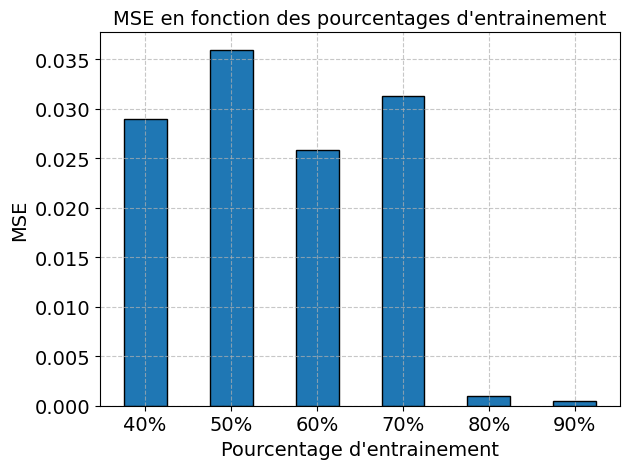

In [14]:

# Définition des pourcentages de fractionnement (30% à 90%)
split_percentages_range = range(4, 10)

successful_splits = []
errors = []

best_score = float('inf')
best_split = None

for p in split_percentages_range:
    percentage = p / 10.0

    try:
        print(f"--- Test pour un split de {int(p*10)}% / {int(100 - p*10)}% ---")
        train_data, test_data = train_test_split(pmi_data, train_size=percentage, shuffle=False)

        if len(test_data) <= 6:
            print(f"Jeu de test trop petit ({len(test_data)} lignes), on ignore ce split.")
            continue

        # Préparation des données
        (X_train_retail_sales, X_train_Inflation, X_train_GDP, X_train_GPDIC1,
         X_train_indicator4, X_train_indicator5, X_train_indicator6, X_train_indicator7,
         X_train_indicator8, X_train_indicator9, X_train_indicator10,
         y_train_retail_sales, y_train_Inflation, y_train_GDP, y_train_GPDIC1,
         y_train_indicator4, y_train_indicator5, y_train_indicator6, y_train_indicator7,
         y_train_indicator8, y_train_indicator9, y_train_indicator10) = prepare_data(train_data)

        (X_test_retail_sales, X_test_Inflation, X_test_GDP, X_test_GPDIC1,
         X_test_indicator4, X_test_indicator5, X_test_indicator6, X_test_indicator7,
         X_test_indicator8, X_test_indicator9, X_test_indicator10,
         y_test_retail_sales, y_test_Inflation, y_test_GDP, y_test_GPDIC1,
         y_test_indicator4, y_test_indicator5, y_test_indicator6, y_test_indicator7,
         y_test_indicator8, y_test_indicator9, y_test_indicator10) = prepare_data(test_data)

        X_train_combined_retail_sales = np.concatenate((X_train_retail_sales, X_train_Inflation, X_train_GDP, X_train_GPDIC1, X_train_indicator4, X_train_indicator5, X_train_indicator6, X_train_indicator7, X_train_indicator8, X_train_indicator9, X_train_indicator10), axis=1)
        model_retail_sales = LinearRegression()
        model_retail_sales.fit(X_train_combined_retail_sales, y_train_retail_sales)

        X_test_combined_retail_sales = np.concatenate((X_test_retail_sales, X_test_Inflation, X_test_GDP, X_test_GPDIC1, X_test_indicator4, X_test_indicator5, X_test_indicator6, X_test_indicator7, X_test_indicator8, X_test_indicator9, X_test_indicator10), axis=1)
        y_pred_combined_retail_sales = model_retail_sales.predict(X_test_combined_retail_sales)

        mse_retail_sales = mean_squared_error(y_test_retail_sales, y_pred_combined_retail_sales)

        print(f"  -> Résultat : MSE pour {int(p*10)}% d'entraînement = {mse_retail_sales:.4f}")

        errors.append(mse_retail_sales)
        successful_splits.append(p)

        if mse_retail_sales < best_score:
            best_score = mse_retail_sales
            best_split = percentage

    except Exception as e:
        print(f"Erreur pour le split {int(p*10)}%: {e}. On ignore ce split.")
        continue

# ==========================================================
# GRAPHE
# ==========================================================

# Vérifier s'il y a des résultats à afficher
if not errors:
    print("\nAucun split n'a pu être traité. Impossible de générer le graphique.")
else:
    print(f"\nMeilleur split trouvé : {best_split*100:.0f}% d'entraînement avec un MSE de {best_score:.4f}")

    # Créer le graphique à barres
    # Note : `plt.bar` a besoin de la même longueur pour les x et les y.
    # On utilise `successful_splits` pour les x, qui contient uniquement les pourcentages qui ont fonctionné.
    plt.bar([f'{s*10}%' for s in successful_splits], errors, width=0.5, edgecolor='black')
    plt.xlabel('Pourcentage d\'entrainement', fontsize=14)
    plt.ylabel('MSE', fontsize=14)
    plt.title('MSE en fonction des pourcentages d\'entrainement', fontsize=14)

    # Définir les étiquettes de l'axe des x en pourcentage avec le symbole %
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Ajout de la grille
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Affichage du graphe
    plt.tight_layout()
    plt.show()

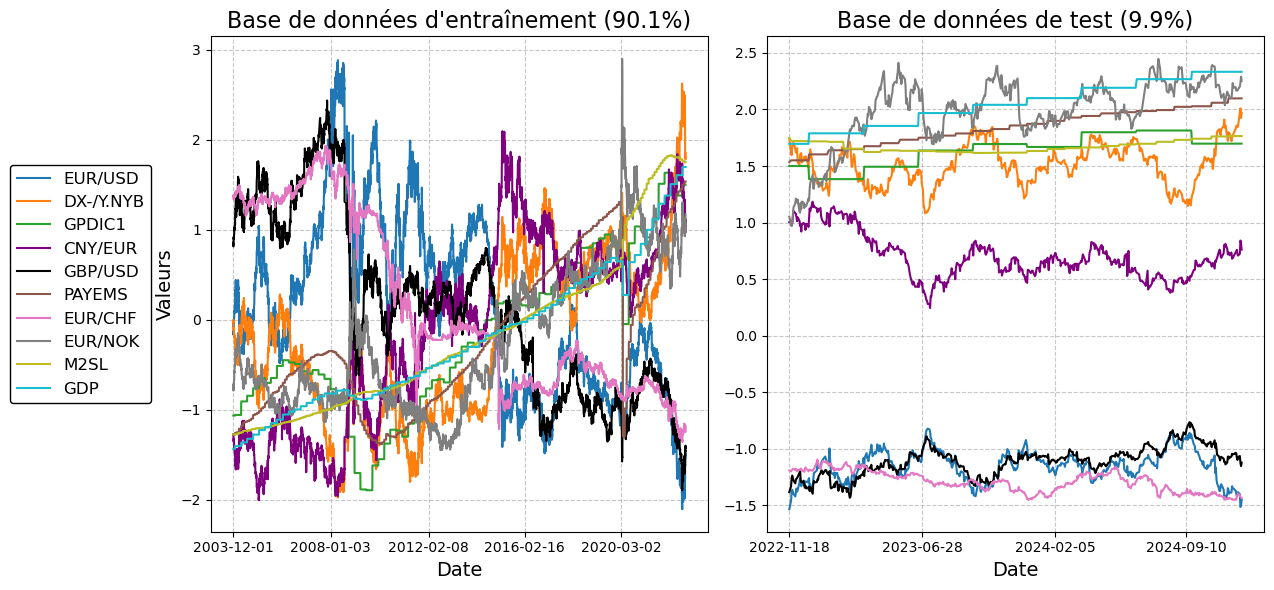

In [15]:

# Séparation des données en fonction de l'index pour l'entraînement et le test
train_data, test_data = train_test_split(pmi_data, train_size=best_split, shuffle=False)

# Préparation des données d'entraînement et de test
(X_train_retail_sales, X_train_Inflation, X_train_GDP, X_train_GPDIC1,
 X_train_indicator4, X_train_indicator5, X_train_indicator6, X_train_indicator7,
 X_train_indicator8, X_train_indicator9, X_train_indicator10,
 y_train_retail_sales, y_train_Inflation, y_train_GDP, y_train_GPDIC1,
 y_train_indicator4, y_train_indicator5, y_train_indicator6, y_train_indicator7,
 y_train_indicator8, y_train_indicator9, y_train_indicator10) = prepare_data(train_data)

(X_test_retail_sales, X_test_Inflation, X_test_GDP, X_test_GPDIC1,
 X_test_indicator4, X_test_indicator5, X_test_indicator6, X_test_indicator7,
 X_test_indicator8, X_test_indicator9, X_test_indicator10,
 y_test_retail_sales, y_test_Inflation, y_test_GDP, y_test_GPDIC1,
 y_test_indicator4, y_test_indicator5, y_test_indicator6, y_test_indicator7,
 y_test_indicator8, y_test_indicator9, y_test_indicator10) = prepare_data(test_data)


# Couleurs pour les lignes (10 couleurs)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#800080', '#000000',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Calcul des tailles
train_size = len(X_train_GDP)
test_size = len(X_test_GDP)
total_size = train_size + test_size

# Pourcentages
train_pct = round(100 * train_size / total_size, 1)
test_pct = round(100 * test_size / total_size, 1)

# Extraire les dates
train_dates = pmi_data['Date'][:train_size]
test_dates = pmi_data['Date'][train_size:train_size + test_size]

# Création de la figure
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Données d'entraînement avec labels
train_data = [
    (X_train_retail_sales, colors[0], chosen_currency),
    (X_train_Inflation, colors[1], first_indicator),
    (X_train_GDP, colors[2], second_indicator),
    (X_train_GPDIC1, colors[3], third_indicator),
    (X_train_indicator4, colors[4], fourth_indicator),
    (X_train_indicator5, colors[5], fifth_indicator),
    (X_train_indicator6, colors[6], sixth_indicator),
    (X_train_indicator7, colors[7], seventh_indicator),
    (X_train_indicator8, colors[8], eighth_indicator),
    (X_train_indicator9, colors[9], ninth_indicator)
]

# Données de test
test_data = [
    X_test_retail_sales,
    X_test_Inflation,
    X_test_GDP,
    X_test_GPDIC1,
    X_test_indicator4,
    X_test_indicator5,
    X_test_indicator6,
    X_test_indicator7,
    X_test_indicator8,
    X_test_indicator9
]

# Subplot 1 - Entraînement
for data, color, label in train_data:
    axs[0].plot(train_dates, [sample[1] for sample in data], color=color, label=label)

axs[0].set_xticks(train_dates[::1000])
axs[0].set_xlabel('Date', fontsize=14)
axs[0].set_ylabel('Valeurs', fontsize=14)
axs[0].set_title(f'Base de données d\'entraînement ({train_pct}%)', fontsize=16)
axs[0].grid(True, linestyle='--', alpha=0.7)

# Subplot 2 - Test
for i, data in enumerate(test_data):
    axs[1].plot(test_dates, [sample[1] for sample in data], color=colors[i])

axs[1].set_xticks(test_dates[::150])
axs[1].set_xlabel('Date', fontsize=14)
axs[1].set_title(f'Base de données de test ({test_pct}%)', fontsize=16)
axs[1].grid(True, linestyle='--', alpha=0.7)

# Légende (graphique gauche)
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles, labels,
              loc='center left',
              bbox_to_anchor=(-0.42, 0.5),
              fontsize=12,
              frameon=True,
              fancybox=True,
              edgecolor='black',
              framealpha=1)

# Mise en page
plt.tight_layout(rect=[0.18, 0, 1, 1])

# Affichage
plt.show()


In [16]:

# Concaténation des caractéristiques pour l'ensemble de train pour retail_sales
X_train_combined_retail_sales = np.concatenate((X_train_retail_sales, X_train_Inflation,
                                              X_train_GDP, X_train_GPDIC1,
                                              X_train_indicator4, X_train_indicator5,
                                              X_train_indicator6, X_train_indicator7,
                                              X_train_indicator8, X_train_indicator9,
                                              X_train_indicator10), axis=1)

# Concaténation des caractéristiques pour l'ensemble de train pour Inflation
X_train_combined_Inflation = np.concatenate((X_train_Inflation, X_train_retail_sales,
                                          X_train_GDP, X_train_GPDIC1,
                                          X_train_indicator4, X_train_indicator5,
                                          X_train_indicator6, X_train_indicator7,
                                          X_train_indicator8, X_train_indicator9,
                                          X_train_indicator10), axis=1)

# Concaténation des caractéristiques pour l'ensemble de train pour GDP
X_train_combined_GDP = np.concatenate((X_train_GDP, X_train_retail_sales,
                                    X_train_Inflation, X_train_GPDIC1,
                                    X_train_indicator4, X_train_indicator5,
                                    X_train_indicator6, X_train_indicator7,
                                    X_train_indicator8, X_train_indicator9,
                                    X_train_indicator10), axis=1)

# Concaténation des caractéristiques pour l'ensemble de train pour GPDIC1
X_train_combined_GPDIC1 = np.concatenate((X_train_GPDIC1, X_train_retail_sales,
                                        X_train_Inflation, X_train_GDP,
                                        X_train_indicator4, X_train_indicator5,
                                        X_train_indicator6, X_train_indicator7,
                                        X_train_indicator8, X_train_indicator9,
                                        X_train_indicator10), axis=1)

# Concaténation des caractéristiques pour l'ensemble de train pour indicator4
X_train_combined_indicator4 = np.concatenate((X_train_indicator4, X_train_retail_sales,
                                            X_train_Inflation, X_train_GDP, X_train_GPDIC1,
                                            X_train_indicator5, X_train_indicator6,
                                            X_train_indicator7, X_train_indicator8,
                                            X_train_indicator9, X_train_indicator10), axis=1)

# Concaténation des caractéristiques pour l'ensemble de train pour indicator5
X_train_combined_indicator5 = np.concatenate((X_train_indicator5, X_train_retail_sales,
                                            X_train_Inflation, X_train_GDP, X_train_GPDIC1,
                                            X_train_indicator4, X_train_indicator6,
                                            X_train_indicator7, X_train_indicator8,
                                            X_train_indicator9, X_train_indicator10), axis=1)

# Concaténation des caractéristiques pour l'ensemble de train pour indicator6
X_train_combined_indicator6 = np.concatenate((X_train_indicator6, X_train_retail_sales,
                                            X_train_Inflation, X_train_GDP, X_train_GPDIC1,
                                            X_train_indicator4, X_train_indicator5,
                                            X_train_indicator7, X_train_indicator8,
                                            X_train_indicator9, X_train_indicator10), axis=1)

# Concaténation des caractéristiques pour l'ensemble de train pour indicator7
X_train_combined_indicator7 = np.concatenate((X_train_indicator7, X_train_retail_sales,
                                            X_train_Inflation, X_train_GDP, X_train_GPDIC1,
                                            X_train_indicator4, X_train_indicator5,
                                            X_train_indicator6, X_train_indicator8,
                                            X_train_indicator9, X_train_indicator10), axis=1)

# Concaténation des caractéristiques pour l'ensemble de train pour indicator8
X_train_combined_indicator8 = np.concatenate((X_train_indicator8, X_train_retail_sales,
                                            X_train_Inflation, X_train_GDP, X_train_GPDIC1,
                                            X_train_indicator4, X_train_indicator5,
                                            X_train_indicator6, X_train_indicator7,
                                            X_train_indicator9, X_train_indicator10), axis=1)

# Concaténation des caractéristiques pour l'ensemble de train pour indicator9
X_train_combined_indicator9 = np.concatenate((X_train_indicator9, X_train_retail_sales,
                                            X_train_Inflation, X_train_GDP, X_train_GPDIC1,
                                            X_train_indicator4, X_train_indicator5,
                                            X_train_indicator6, X_train_indicator7,
                                            X_train_indicator8, X_train_indicator10), axis=1)

# Concaténation des caractéristiques pour l'ensemble de train pour indicator10
X_train_combined_indicator10 = np.concatenate((X_train_indicator10, X_train_retail_sales,
                                            X_train_Inflation, X_train_GDP, X_train_GPDIC1,
                                            X_train_indicator4, X_train_indicator5,
                                            X_train_indicator6, X_train_indicator7,
                                            X_train_indicator8, X_train_indicator9), axis=1)

#####################################################################################################
#####################################################################################################

# Initialisation du modèle de régression linéaire pour les ventes au détail
model_retail_sales = LinearRegression()
model_retail_sales.fit(X_train_combined_retail_sales, y_train_retail_sales)

# Initialisation du modèle de régression linéaire pour l'inflation
model_Inflation = LinearRegression()
model_Inflation.fit(X_train_combined_Inflation, y_train_Inflation)

# Initialisation du modèle de régression linéaire pour le PIB
model_GDP = LinearRegression()
model_GDP.fit(X_train_combined_GDP, y_train_GDP)

# Initialisation du modèle de régression linéaire pour le GPDIC1
model_GPDIC1 = LinearRegression()
model_GPDIC1.fit(X_train_combined_GPDIC1, y_train_GPDIC1)

# Initialisation des modèles pour les nouveaux indicateurs
model_indicator4 = LinearRegression()
model_indicator4.fit(X_train_combined_indicator4, y_train_indicator4)

model_indicator5 = LinearRegression()
model_indicator5.fit(X_train_combined_indicator5, y_train_indicator5)

model_indicator6 = LinearRegression()
model_indicator6.fit(X_train_combined_indicator6, y_train_indicator6)

model_indicator7 = LinearRegression()
model_indicator7.fit(X_train_combined_indicator7, y_train_indicator7)

model_indicator8 = LinearRegression()
model_indicator8.fit(X_train_combined_indicator8, y_train_indicator8)

model_indicator9 = LinearRegression()
model_indicator9.fit(X_train_combined_indicator9, y_train_indicator9)

model_indicator10 = LinearRegression()
model_indicator10.fit(X_train_combined_indicator10, y_train_indicator10)

#####################################################################################################
#####################################################################################################

# Prédiction sur l'ensemble d'entraînement pour retail_sales en se basant sur les caractéristiques combinées
y_train_pred_retail_sales = model_retail_sales.predict(X_train_combined_retail_sales)

# Prédiction sur l'ensemble d'entraînement pour Inflation en se basant sur les caractéristiques combinées
y_train_pred_Inflation = model_Inflation.predict(X_train_combined_Inflation)

# Prédiction sur l'ensemble d'entraînement pour GDP en se basant sur les caractéristiques combinées
y_train_pred_GDP = model_GDP.predict(X_train_combined_GDP)

# Prédiction sur l'ensemble d'entraînement pour GPDIC1 en se basant sur les caractéristiques combinées
y_train_pred_GPDIC1 = model_GPDIC1.predict(X_train_combined_GPDIC1)

# Prédiction sur l'ensemble d'entraînement pour indicator4 en se basant sur les caractéristiques combinées
y_train_pred_indicator4 = model_indicator4.predict(X_train_combined_indicator4)

# Prédiction sur l'ensemble d'entraînement pour indicator5 en se basant sur les caractéristiques combinées
y_train_pred_indicator5 = model_indicator5.predict(X_train_combined_indicator5)

# Prédiction sur l'ensemble d'entraînement pour indicator6 en se basant sur les caractéristiques combinées
y_train_pred_indicator6 = model_indicator6.predict(X_train_combined_indicator6)

# Prédiction sur l'ensemble d'entraînement pour indicator7 en se basant sur les caractéristiques combinées
y_train_pred_indicator7 = model_indicator7.predict(X_train_combined_indicator7)

# Prédiction sur l'ensemble d'entraînement pour indicator8 en se basant sur les caractéristiques combinées
y_train_pred_indicator8 = model_indicator8.predict(X_train_combined_indicator8)

# Prédiction sur l'ensemble d'entraînement pour indicator9 en se basant sur les caractéristiques combinées
y_train_pred_indicator9 = model_indicator9.predict(X_train_combined_indicator9)

# Prédiction sur l'ensemble d'entraînement pour indicator10 en se basant sur les caractéristiques combinées
y_train_pred_indicator10 = model_indicator10.predict(X_train_combined_indicator10)


# Empêche l'affichage des nombres en notation scientifique (par exemple, 1.23e-10)
np.set_printoptions(suppress=True)

# Calcul des mesures de performance pour retail_sales
train_rmse_retail_sales = np.sqrt(mean_squared_error(y_train_retail_sales, y_train_pred_retail_sales))
train_r2_retail_sales = r2_score(y_train_retail_sales, y_train_pred_retail_sales)
train_mae_retail_sales = mean_absolute_error(y_train_retail_sales, y_train_pred_retail_sales)

# Calcul des mesures de performance pour Inflation
train_rmse_Inflation = np.sqrt(mean_squared_error(y_train_Inflation, y_train_pred_Inflation))
train_r2_Inflation = r2_score(y_train_Inflation, y_train_pred_Inflation)
train_mae_Inflation = mean_absolute_error(y_train_Inflation, y_train_pred_Inflation)

# Calcul des mesures de performance pour GDP
train_rmse_GDP = np.sqrt(mean_squared_error(y_train_GDP, y_train_pred_GDP))
train_r2_GDP = r2_score(y_train_GDP, y_train_pred_GDP)
train_mae_GDP = mean_absolute_error(y_train_GDP, y_train_pred_GDP)

# Calcul des mesures de performance pour GPDIC1
train_rmse_GPDIC1 = np.sqrt(mean_squared_error(y_train_GPDIC1, y_train_pred_GPDIC1))
train_r2_GPDIC1 = r2_score(y_train_GPDIC1, y_train_pred_GPDIC1)
train_mae_GPDIC1 = mean_absolute_error(y_train_GPDIC1, y_train_pred_GPDIC1)

# Calcul des mesures de performance pour indicator4
train_rmse_indicator4 = np.sqrt(mean_squared_error(y_train_indicator4, y_train_pred_indicator4))
train_r2_indicator4 = r2_score(y_train_indicator4, y_train_pred_indicator4)
train_mae_indicator4 = mean_absolute_error(y_train_indicator4, y_train_pred_indicator4)

# Calcul des mesures de performance pour indicator5
train_rmse_indicator5 = np.sqrt(mean_squared_error(y_train_indicator5, y_train_pred_indicator5))
train_r2_indicator5 = r2_score(y_train_indicator5, y_train_pred_indicator5)
train_mae_indicator5 = mean_absolute_error(y_train_indicator5, y_train_pred_indicator5)

# Calcul des mesures de performance pour indicator6
train_rmse_indicator6 = np.sqrt(mean_squared_error(y_train_indicator6, y_train_pred_indicator6))
train_r2_indicator6 = r2_score(y_train_indicator6, y_train_pred_indicator6)
train_mae_indicator6 = mean_absolute_error(y_train_indicator6, y_train_pred_indicator6)

# Calcul des mesures de performance pour indicator7
train_rmse_indicator7 = np.sqrt(mean_squared_error(y_train_indicator7, y_train_pred_indicator7))
train_r2_indicator7 = r2_score(y_train_indicator7, y_train_pred_indicator7)
train_mae_indicator7 = mean_absolute_error(y_train_indicator7, y_train_pred_indicator7)

# Calcul des mesures de performance pour indicator8
train_rmse_indicator8 = np.sqrt(mean_squared_error(y_train_indicator8, y_train_pred_indicator8))
train_r2_indicator8 = r2_score(y_train_indicator8, y_train_pred_indicator8)
train_mae_indicator8 = mean_absolute_error(y_train_indicator8, y_train_pred_indicator8)

# Calcul des mesures de performance pour indicator9
train_rmse_indicator9 = np.sqrt(mean_squared_error(y_train_indicator9, y_train_pred_indicator9))
train_r2_indicator9 = r2_score(y_train_indicator9, y_train_pred_indicator9)
train_mae_indicator9 = mean_absolute_error(y_train_indicator9, y_train_pred_indicator9)

# Calcul des mesures de performance pour indicator10
train_rmse_indicator10 = np.sqrt(mean_squared_error(y_train_indicator10, y_train_pred_indicator10))
train_r2_indicator10 = r2_score(y_train_indicator10, y_train_pred_indicator10)
train_mae_indicator10 = mean_absolute_error(y_train_indicator10, y_train_pred_indicator10)

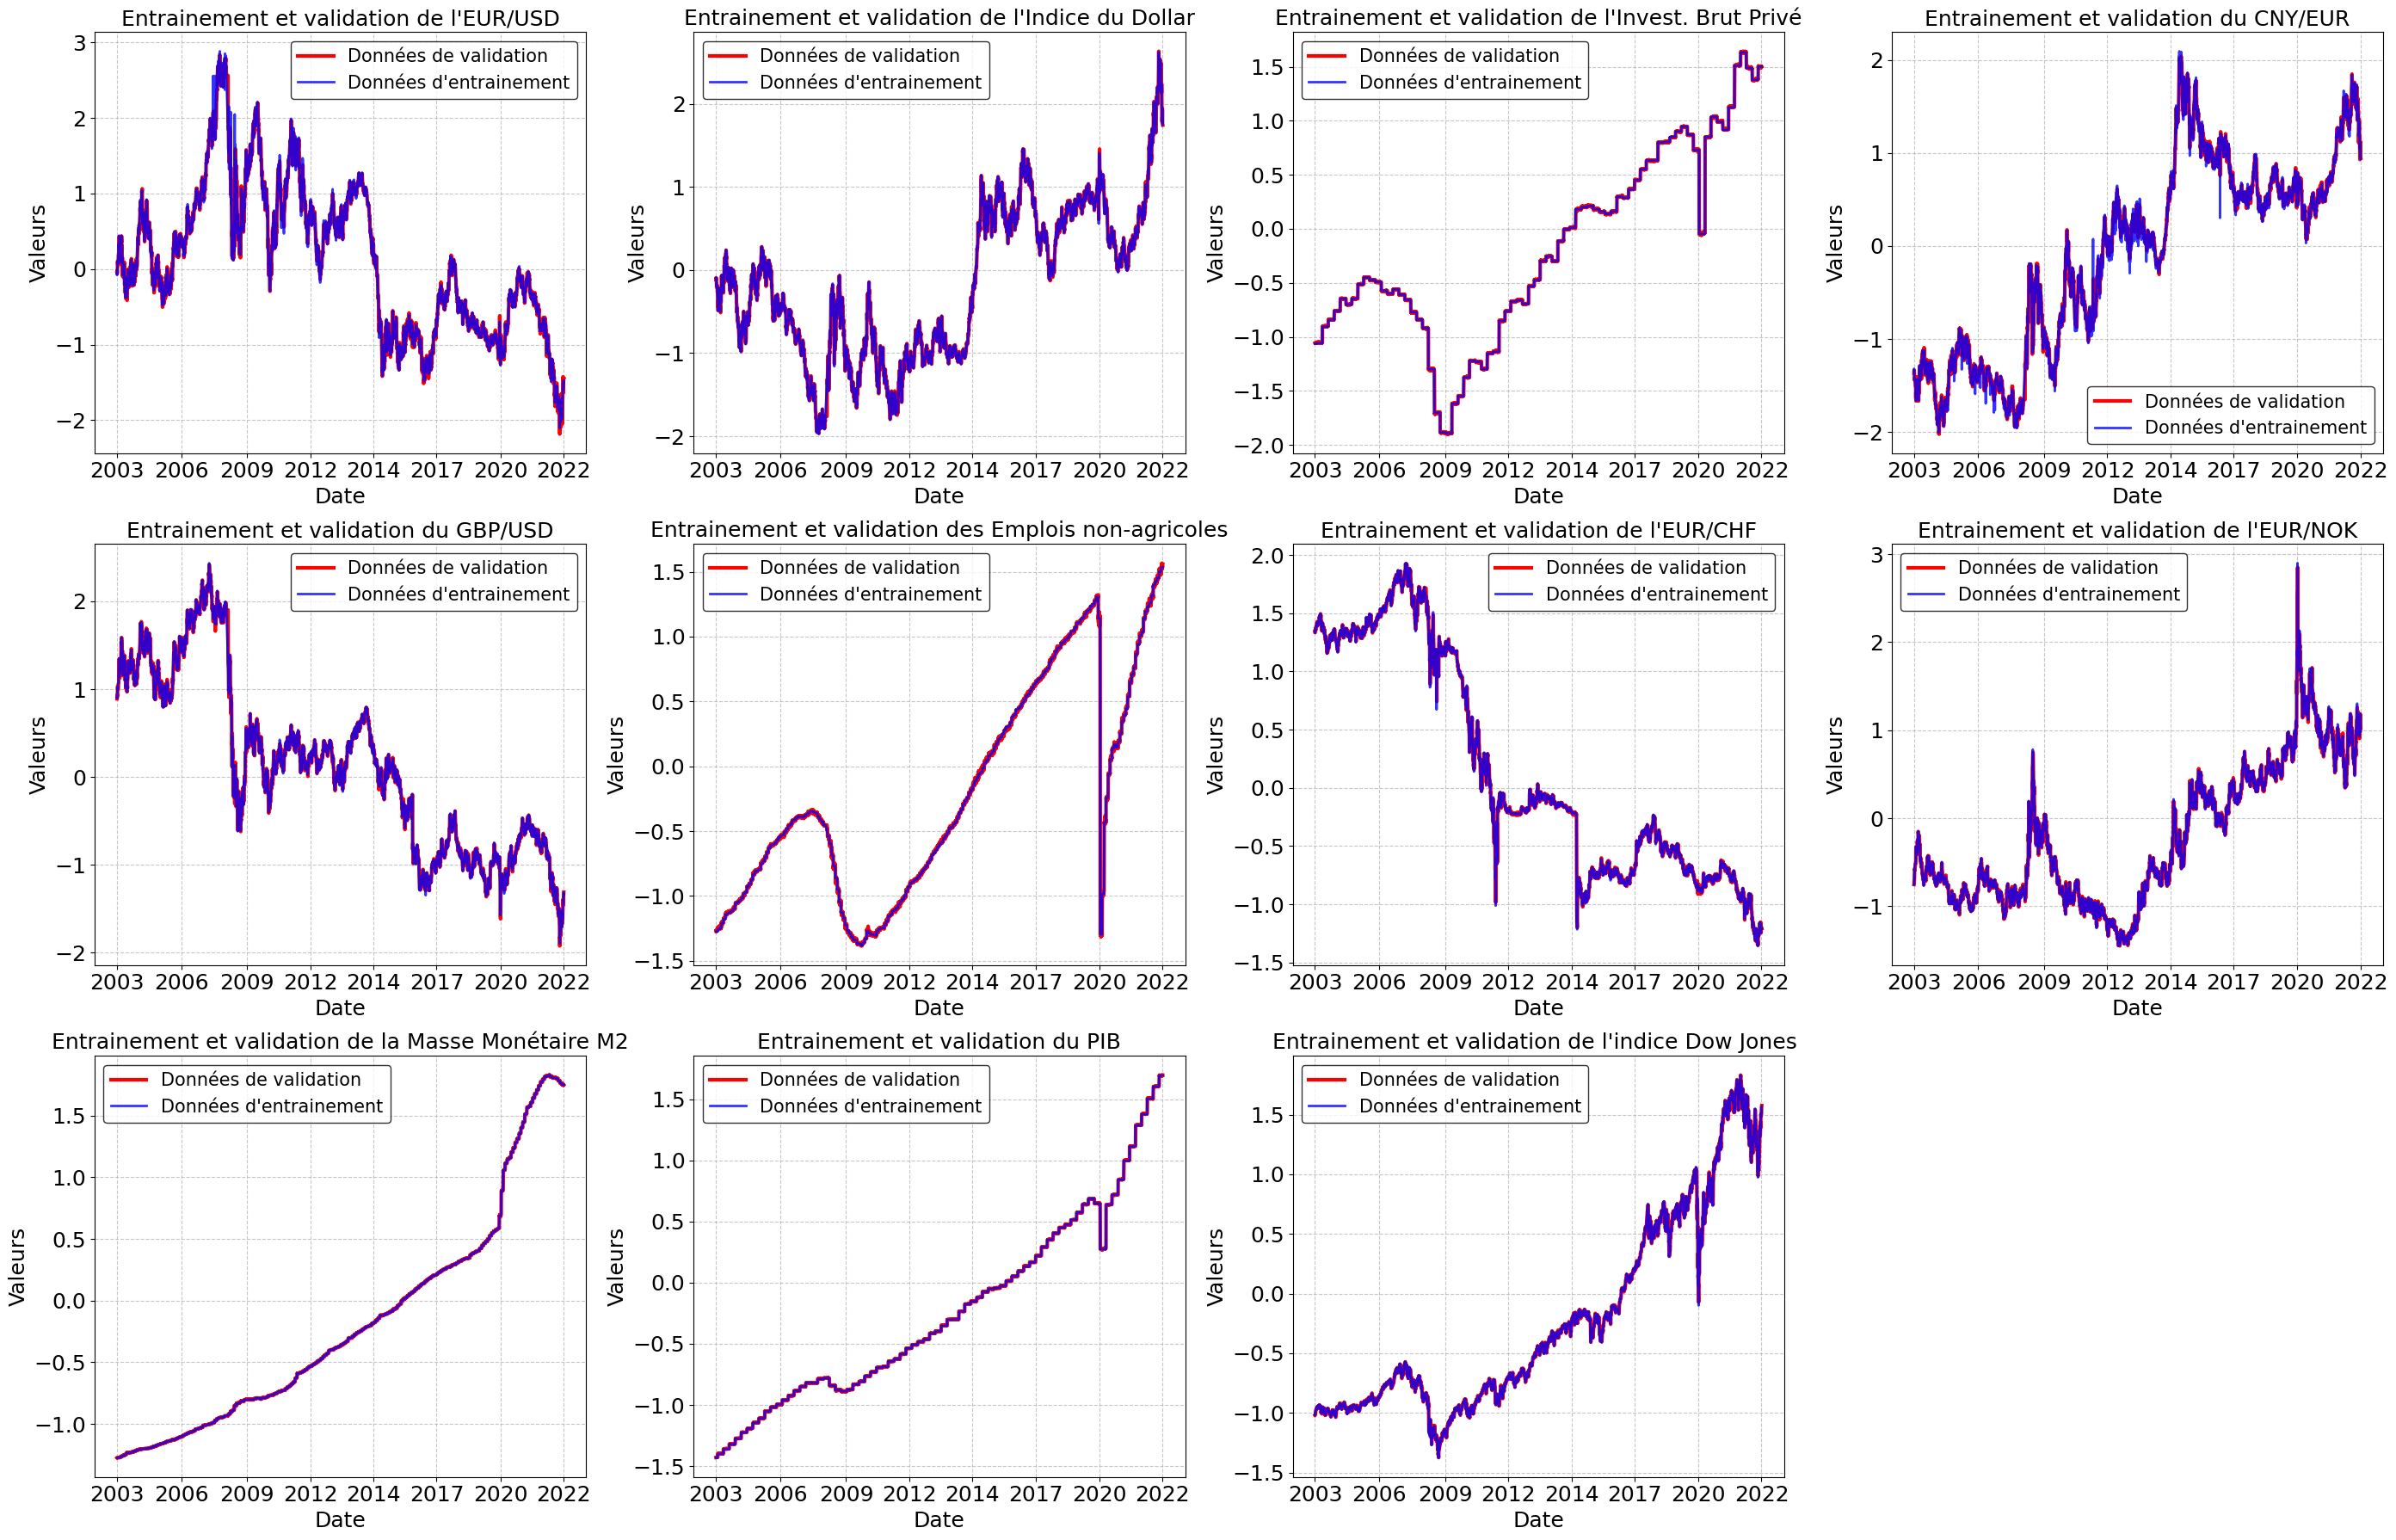

In [17]:
#pmi_data avec juste les dates prédites
pmi_data_nv = pmi_data.iloc[6:]

pmi_data_nv['Date']=pd.to_datetime(pmi_data_nv['Date'])

# Sélection d'un échantillon de dates pour l'affichage
sampled_dates = pmi_data_nv['Date'][:len(y_train_pred_GDP):len(y_train_pred_GDP)//10]
dates_train = pmi_data_nv['Date'][:len(y_train_pred_GDP)]


# ==============================================================================
# 2. CONFIGURATION DE LA FIGURE ET DE LA GRILLE (identique à l'original)
# ==============================================================================

# Définition de la grille de subplots
n_cols = 4
# Le nombre total d'indicateurs est 11
n_rows = (11 + n_cols - 1) // n_cols  # Calcul du nombre de lignes nécessaires

# Création de la figure globale avec la taille originale
plt.figure(figsize=(28, 6 * n_rows))


# ==============================================================================
# 3. TRACÉ MANUEL DE CHAQUE GRAPHIQUE, UN PAR UN
# ==============================================================================

# --- Graphique 1: chosen_currency ---
plt.subplot(n_rows, n_cols, 1)
plt.plot(dates_train, y_train_pred_retail_sales, label='Données de validation', color='red', linestyle='-', linewidth=3)
plt.plot(dates_train, pmi_data_nv[chosen_currency][:len(y_train_pred_retail_sales)], label='Données d\'entrainement', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Valeurs', fontsize=18)
plt.title(f'Entrainement et validation de l\'EUR/USD', fontsize=18)
plt.legend(edgecolor='black',fontsize=15)
plt.xticks(sampled_dates, rotation=0, fontsize=18)
plt.yticks(fontsize=18)
# Utilisation de YearLocator et DateFormatter de matplotlib.dates pour formater les dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', labelsize=18)
# Échantillonnage des dates pour définir les étiquettes à intervalles réguliers
sampled_dates = dates_train[::len(dates_train)//7]  # Ajustez ce facteur pour contrôler le nombre d'étiquettes
ax.set_xticks(sampled_dates)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=18)
plt.yticks(fontsize=18)

# --- Graphique 2: first_indicator ---
plt.subplot(n_rows, n_cols, 2)
plt.plot(dates_train, y_train_pred_Inflation, label='Données de validation', color='red', linestyle='-', linewidth=3)
plt.plot(dates_train, pmi_data_nv[first_indicator][:len(y_train_pred_Inflation)], label='Données d\'entrainement', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Valeurs', fontsize=18)
plt.title(f'Entrainement et validation de l\'Indice du Dollar', fontsize=18)
plt.legend(edgecolor='black',fontsize=15)
plt.xticks(sampled_dates, rotation=0, fontsize=18)
plt.yticks(fontsize=18)
# Utilisation de YearLocator et DateFormatter de matplotlib.dates pour formater les dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', labelsize=18)
# Échantillonnage des dates pour définir les étiquettes à intervalles réguliers
sampled_dates = dates_train[::len(dates_train)//7]  # Ajustez ce facteur pour contrôler le nombre d'étiquettes
ax.set_xticks(sampled_dates)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=18)
plt.yticks(fontsize=18)

# --- Graphique 3: second_indicator ---
plt.subplot(n_rows, n_cols, 3)
plt.plot(dates_train, y_train_pred_GDP, label='Données de validation', color='red', linestyle='-', linewidth=3)
plt.plot(dates_train, pmi_data_nv[second_indicator][:len(y_train_pred_GDP)], label='Données d\'entrainement', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Valeurs', fontsize=18)
plt.title(f'Entrainement et validation de l\'Invest. Brut Privé', fontsize=18)
plt.legend(edgecolor='black',fontsize=15)
plt.xticks(sampled_dates, rotation=0, fontsize=18)
plt.yticks(fontsize=18)
# Utilisation de YearLocator et DateFormatter de matplotlib.dates pour formater les dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', labelsize=18)
# Échantillonnage des dates pour définir les étiquettes à intervalles réguliers
sampled_dates = dates_train[::len(dates_train)//7]  # Ajustez ce facteur pour contrôler le nombre d'étiquettes
ax.set_xticks(sampled_dates)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=18)
plt.yticks(fontsize=18)

# --- Graphique 4: third_indicator ---
plt.subplot(n_rows, n_cols, 4)
plt.plot(dates_train, y_train_pred_GPDIC1, label='Données de validation', color='red', linestyle='-', linewidth=3)
plt.plot(dates_train, pmi_data_nv[third_indicator][:len(y_train_pred_GPDIC1)], label='Données d\'entrainement', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Valeurs', fontsize=18)
plt.title(f'Entrainement et validation du {third_indicator}', fontsize=18)
plt.legend(edgecolor='black',fontsize=15)
plt.xticks(sampled_dates, rotation=0, fontsize=18)
plt.yticks(fontsize=18)
# Utilisation de YearLocator et DateFormatter de matplotlib.dates pour formater les dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', labelsize=18)
# Échantillonnage des dates pour définir les étiquettes à intervalles réguliers
sampled_dates = dates_train[::len(dates_train)//7]  # Ajustez ce facteur pour contrôler le nombre d'étiquettes
ax.set_xticks(sampled_dates)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=18)
plt.yticks(fontsize=18)

# --- Graphique 5: fourth_indicator ---
plt.subplot(n_rows, n_cols, 5)
plt.plot(dates_train, y_train_pred_indicator4, label='Données de validation', color='red', linestyle='-', linewidth=3)
plt.plot(dates_train, pmi_data_nv[fourth_indicator][:len(y_train_pred_indicator4)], label='Données d\'entrainement', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Valeurs', fontsize=18)
plt.title(f'Entrainement et validation du {fourth_indicator}', fontsize=18)
plt.legend(edgecolor='black',fontsize=15)
plt.xticks(sampled_dates, rotation=0, fontsize=18)
plt.yticks(fontsize=18)
# Utilisation de YearLocator et DateFormatter de matplotlib.dates pour formater les dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', labelsize=18)
# Échantillonnage des dates pour définir les étiquettes à intervalles réguliers
sampled_dates = dates_train[::len(dates_train)//7]  # Ajustez ce facteur pour contrôler le nombre d'étiquettes
ax.set_xticks(sampled_dates)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=18)
plt.yticks(fontsize=18)

# --- Graphique 6: fifth_indicator ---
plt.subplot(n_rows, n_cols, 6)
plt.plot(dates_train, y_train_pred_indicator5, label='Données de validation', color='red', linestyle='-', linewidth=3)
plt.plot(dates_train, pmi_data_nv[fifth_indicator][:len(y_train_pred_indicator5)], label='Données d\'entrainement', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Valeurs', fontsize=18)
plt.title(f'Entrainement et validation des Emplois non-agricoles', fontsize=18)
plt.legend(edgecolor='black',fontsize=15)
plt.xticks(sampled_dates, rotation=0, fontsize=18)
plt.yticks(fontsize=18)
# Utilisation de YearLocator et DateFormatter de matplotlib.dates pour formater les dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', labelsize=18)
# Échantillonnage des dates pour définir les étiquettes à intervalles réguliers
sampled_dates = dates_train[::len(dates_train)//7]  # Ajustez ce facteur pour contrôler le nombre d'étiquettes
ax.set_xticks(sampled_dates)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=18)
plt.yticks(fontsize=18)

# --- Graphique 7: sixth_indicator ---
plt.subplot(n_rows, n_cols, 7)
plt.plot(dates_train, y_train_pred_indicator6, label='Données de validation', color='red', linestyle='-', linewidth=3)
plt.plot(dates_train, pmi_data_nv[sixth_indicator][:len(y_train_pred_indicator6)], label='Données d\'entrainement', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Valeurs', fontsize=18)
plt.title(f'Entrainement et validation de l\'{sixth_indicator}', fontsize=18)
plt.legend(edgecolor='black',fontsize=15)
plt.xticks(sampled_dates, rotation=0, fontsize=18)
plt.yticks(fontsize=18)
# Utilisation de YearLocator et DateFormatter de matplotlib.dates pour formater les dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', labelsize=18)
# Échantillonnage des dates pour définir les étiquettes à intervalles réguliers
sampled_dates = dates_train[::len(dates_train)//7]  # Ajustez ce facteur pour contrôler le nombre d'étiquettes
ax.set_xticks(sampled_dates)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=18)
plt.yticks(fontsize=18)

# --- Graphique 8: seventh_indicator ---
plt.subplot(n_rows, n_cols, 8)
plt.plot(dates_train, y_train_pred_indicator7, label='Données de validation', color='red', linestyle='-', linewidth=3)
plt.plot(dates_train, pmi_data_nv[seventh_indicator][:len(y_train_pred_indicator7)], label='Données d\'entrainement', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Valeurs', fontsize=18)
plt.title(f'Entrainement et validation de l\'{seventh_indicator}', fontsize=18)
plt.legend(edgecolor='black',fontsize=15)
plt.xticks(sampled_dates, rotation=0, fontsize=18)
plt.yticks(fontsize=18)
# Utilisation de YearLocator et DateFormatter de matplotlib.dates pour formater les dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', labelsize=18)
# Échantillonnage des dates pour définir les étiquettes à intervalles réguliers
sampled_dates = dates_train[::len(dates_train)//7]  # Ajustez ce facteur pour contrôler le nombre d'étiquettes
ax.set_xticks(sampled_dates)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=18)
plt.yticks(fontsize=18)

# --- Graphique 9: eighth_indicator ---
plt.subplot(n_rows, n_cols, 9)
plt.plot(dates_train, y_train_pred_indicator8, label='Données de validation', color='red', linestyle='-', linewidth=3)
plt.plot(dates_train, pmi_data_nv[eighth_indicator][:len(y_train_pred_indicator8)], label='Données d\'entrainement', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Valeurs', fontsize=18)
plt.title(f'Entrainement et validation de la Masse Monétaire M2', fontsize=18)
plt.legend(edgecolor='black',fontsize=15)
plt.xticks(sampled_dates, rotation=0, fontsize=18)
plt.yticks(fontsize=18)
# Utilisation de YearLocator et DateFormatter de matplotlib.dates pour formater les dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', labelsize=18)
# Échantillonnage des dates pour définir les étiquettes à intervalles réguliers
sampled_dates = dates_train[::len(dates_train)//7]  # Ajustez ce facteur pour contrôler le nombre d'étiquettes
ax.set_xticks(sampled_dates)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=18)
plt.yticks(fontsize=18)

# --- Graphique 10: ninth_indicator ---
plt.subplot(n_rows, n_cols, 10)
plt.plot(dates_train, y_train_pred_indicator9, label='Données de validation', color='red', linestyle='-', linewidth=3)
plt.plot(dates_train, pmi_data_nv[ninth_indicator][:len(y_train_pred_indicator9)], label='Données d\'entrainement', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Valeurs', fontsize=18)
plt.title(f'Entrainement et validation du PIB', fontsize=18)
plt.legend(edgecolor='black',fontsize=15)
plt.xticks(sampled_dates, rotation=0, fontsize=18)
plt.yticks(fontsize=18)
# Utilisation de YearLocator et DateFormatter de matplotlib.dates pour formater les dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', labelsize=18)
# Échantillonnage des dates pour définir les étiquettes à intervalles réguliers
sampled_dates = dates_train[::len(dates_train)//7]  # Ajustez ce facteur pour contrôler le nombre d'étiquettes
ax.set_xticks(sampled_dates)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=18)
plt.yticks(fontsize=18)

# --- Graphique 11: tenth_indicator ---
plt.subplot(n_rows, n_cols, 11)
plt.plot(dates_train, y_train_pred_indicator10, label='Données de validation', color='red', linestyle='-', linewidth=3)
plt.plot(dates_train, pmi_data_nv[tenth_indicator][:len(y_train_pred_indicator10)], label='Données d\'entrainement', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Valeurs', fontsize=18)
plt.title(f'Entrainement et validation de l\'indice Dow Jones ', fontsize=18)
plt.legend(edgecolor='black',fontsize=15)
plt.xticks(sampled_dates, rotation=0, fontsize=18)
plt.yticks(fontsize=18)
# Utilisation de YearLocator et DateFormatter de matplotlib.dates pour formater les dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', labelsize=18)
# Échantillonnage des dates pour définir les étiquettes à intervalles réguliers
sampled_dates = dates_train[::len(dates_train)//7]  # Ajustez ce facteur pour contrôler le nombre d'étiquettes
ax.set_xticks(sampled_dates)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()
plt.show()

In [18]:
# Concaténation des caractéristiques pour l'ensemble de test pour retail_sales
X_test_combined_retail_sales = np.concatenate((X_test_retail_sales, X_test_Inflation,
                                              X_test_GDP, X_test_GPDIC1,
                                              X_test_indicator4, X_test_indicator5,
                                              X_test_indicator6, X_test_indicator7,
                                              X_test_indicator8, X_test_indicator9,
                                              X_test_indicator10), axis=1)

# Concaténation des caractéristiques pour l'ensemble de test pour Inflation
X_test_combined_Inflation = np.concatenate((X_test_Inflation, X_test_retail_sales,
                                          X_test_GDP, X_test_GPDIC1,
                                          X_test_indicator4, X_test_indicator5,
                                          X_test_indicator6, X_test_indicator7,
                                          X_test_indicator8, X_test_indicator9,
                                          X_test_indicator10), axis=1)

# Concaténation des caractéristiques pour l'ensemble de test pour GDP
X_test_combined_GDP = np.concatenate((X_test_GDP, X_test_retail_sales,
                                    X_test_Inflation, X_test_GPDIC1,
                                    X_test_indicator4, X_test_indicator5,
                                    X_test_indicator6, X_test_indicator7,
                                    X_test_indicator8, X_test_indicator9,
                                    X_test_indicator10), axis=1)

# Concaténation des caractéristiques pour l'ensemble de test pour GPDIC1
X_test_combined_GPDIC1 = np.concatenate((X_test_GPDIC1, X_test_retail_sales,
                                       X_test_Inflation, X_test_GDP,
                                       X_test_indicator4, X_test_indicator5,
                                       X_test_indicator6, X_test_indicator7,
                                       X_test_indicator8, X_test_indicator9,
                                       X_test_indicator10), axis=1)

# Concaténation des caractéristiques pour l'ensemble de test pour indicator4
X_test_combined_indicator4 = np.concatenate((X_test_indicator4, X_test_retail_sales,
                                           X_test_Inflation, X_test_GDP, X_test_GPDIC1,
                                           X_test_indicator5, X_test_indicator6,
                                           X_test_indicator7, X_test_indicator8,
                                           X_test_indicator9, X_test_indicator10), axis=1)

# Concaténation des caractéristiques pour l'ensemble de test pour indicator5
X_test_combined_indicator5 = np.concatenate((X_test_indicator5, X_test_retail_sales,
                                           X_test_Inflation, X_test_GDP, X_test_GPDIC1,
                                           X_test_indicator4, X_test_indicator6,
                                           X_test_indicator7, X_test_indicator8,
                                           X_test_indicator9, X_test_indicator10), axis=1)

# Concaténation des caractéristiques pour l'ensemble de test pour indicator6
X_test_combined_indicator6 = np.concatenate((X_test_indicator6, X_test_retail_sales,
                                           X_test_Inflation, X_test_GDP, X_test_GPDIC1,
                                           X_test_indicator4, X_test_indicator5,
                                           X_test_indicator7, X_test_indicator8,
                                           X_test_indicator9, X_test_indicator10), axis=1)

# Concaténation des caractéristiques pour l'ensemble de test pour indicator7
X_test_combined_indicator7 = np.concatenate((X_test_indicator7, X_test_retail_sales,
                                           X_test_Inflation, X_test_GDP, X_test_GPDIC1,
                                           X_test_indicator4, X_test_indicator5,
                                           X_test_indicator6, X_test_indicator8,
                                           X_test_indicator9, X_test_indicator10), axis=1)

# Concaténation des caractéristiques pour l'ensemble de test pour indicator8
X_test_combined_indicator8 = np.concatenate((X_test_indicator8, X_test_retail_sales,
                                           X_test_Inflation, X_test_GDP, X_test_GPDIC1,
                                           X_test_indicator4, X_test_indicator5,
                                           X_test_indicator6, X_test_indicator7,
                                           X_test_indicator9, X_test_indicator10), axis=1)

# Concaténation des caractéristiques pour l'ensemble de test pour indicator9
X_test_combined_indicator9 = np.concatenate((X_test_indicator9, X_test_retail_sales,
                                           X_test_Inflation, X_test_GDP, X_test_GPDIC1,
                                           X_test_indicator4, X_test_indicator5,
                                           X_test_indicator6, X_test_indicator7,
                                           X_test_indicator8, X_test_indicator10), axis=1)

# Concaténation des caractéristiques pour l'ensemble de test pour indicator10
X_test_combined_indicator10 = np.concatenate((X_test_indicator10, X_test_retail_sales,
                                            X_test_Inflation, X_test_GDP, X_test_GPDIC1,
                                            X_test_indicator4, X_test_indicator5,
                                            X_test_indicator6, X_test_indicator7,
                                            X_test_indicator8, X_test_indicator9), axis=1)

# Prédiction sur l'ensemble de test pour retail_sales
y_pred_combined_retail_sales = model_retail_sales.predict(X_test_combined_retail_sales)

# Prédiction sur l'ensemble de test pour Inflation
y_pred_combined_Inflation = model_Inflation.predict(X_test_combined_Inflation)

# Prédiction sur l'ensemble de test pour GDP
y_pred_combined_GDP = model_GDP.predict(X_test_combined_GDP)

# Prédiction sur l'ensemble de test pour GPDIC1
y_pred_combined_GPDIC1 = model_GPDIC1.predict(X_test_combined_GPDIC1)

# Prédiction sur l'ensemble de test pour indicator4
y_pred_combined_indicator4 = model_indicator4.predict(X_test_combined_indicator4)

# Prédiction sur l'ensemble de test pour indicator5
y_pred_combined_indicator5 = model_indicator5.predict(X_test_combined_indicator5)

# Prédiction sur l'ensemble de test pour indicator6
y_pred_combined_indicator6 = model_indicator6.predict(X_test_combined_indicator6)

# Prédiction sur l'ensemble de test pour indicator7
y_pred_combined_indicator7 = model_indicator7.predict(X_test_combined_indicator7)

# Prédiction sur l'ensemble de test pour indicator8
y_pred_combined_indicator8 = model_indicator8.predict(X_test_combined_indicator8)

# Prédiction sur l'ensemble de test pour indicator9
y_pred_combined_indicator9 = model_indicator9.predict(X_test_combined_indicator9)

# Prédiction sur l'ensemble de test pour indicator10
y_pred_combined_indicator10 = model_indicator10.predict(X_test_combined_indicator10)



# Calcul de MSE pour Retail sales
mse_retail_sales = mean_squared_error(y_test_retail_sales, y_pred_combined_retail_sales)
# Calcul de MAE pour Retail sales
mae_retail_sales = mean_absolute_error(y_test_retail_sales, y_pred_combined_retail_sales)
# Calcul de R2 pour Retail sales
r2_retail_sales = r2_score(y_test_retail_sales, y_pred_combined_retail_sales)

# Calcul de MSE pour Scenario_Inflation_Score
mse_Inflation = mean_squared_error(y_test_Inflation, y_pred_combined_Inflation)
# Calcul de MAE pour Scenario_Inflation_Score
mae_Inflation = mean_absolute_error(y_test_Inflation, y_pred_combined_Inflation)
# Calcul de R2 pour Scenario_Inflation_Score
r2_Inflation = r2_score(y_test_Inflation, y_pred_combined_Inflation)

# Calcul de MSE pour Scenario_GDP_Score
mse_GDP = mean_squared_error(y_test_GDP, y_pred_combined_GDP)
# Calcul de MAE pour Scenario_GDP_Score
mae_GDP = mean_absolute_error(y_test_GDP, y_pred_combined_GDP)
# Calcul de R2 pour Scenario_GDP_Score
r2_GDP = r2_score(y_test_GDP, y_pred_combined_GDP)

# Calcul des mesures de performance pour GDPIC1
rmse_GPDIC1 = np.sqrt(mean_squared_error(y_test_GPDIC1, y_pred_combined_GPDIC1))
r2_GPDIC1 = r2_score(y_test_GPDIC1, y_pred_combined_GPDIC1)
mae_GPDIC1 = mean_absolute_error(y_test_GPDIC1, y_pred_combined_GPDIC1)

# Calcul des mesures de performance pour indicator4
rmse_indicator4 = np.sqrt(mean_squared_error(y_test_indicator4, y_pred_combined_indicator4))
r2_indicator4 = r2_score(y_test_indicator4, y_pred_combined_indicator4)
mae_indicator4 = mean_absolute_error(y_test_indicator4, y_pred_combined_indicator4)

# Calcul des mesures de performance pour indicator5
rmse_indicator5 = np.sqrt(mean_squared_error(y_test_indicator5, y_pred_combined_indicator5))
r2_indicator5 = r2_score(y_test_indicator5, y_pred_combined_indicator5)
mae_indicator5 = mean_absolute_error(y_test_indicator5, y_pred_combined_indicator5)

# Calcul des mesures de performance pour indicator6
rmse_indicator6 = np.sqrt(mean_squared_error(y_test_indicator6, y_pred_combined_indicator6))
r2_indicator6 = r2_score(y_test_indicator6, y_pred_combined_indicator6)
mae_indicator6 = mean_absolute_error(y_test_indicator6, y_pred_combined_indicator6)

# Calcul des mesures de performance pour indicator7
rmse_indicator7 = np.sqrt(mean_squared_error(y_test_indicator7, y_pred_combined_indicator7))
r2_indicator7 = r2_score(y_test_indicator7, y_pred_combined_indicator7)
mae_indicator7 = mean_absolute_error(y_test_indicator7, y_pred_combined_indicator7)

# Calcul des mesures de performance pour indicator8
rmse_indicator8 = np.sqrt(mean_squared_error(y_test_indicator8, y_pred_combined_indicator8))
r2_indicator8 = r2_score(y_test_indicator8, y_pred_combined_indicator8)
mae_indicator8 = mean_absolute_error(y_test_indicator8, y_pred_combined_indicator8)

# Calcul des mesures de performance pour indicator9
rmse_indicator9 = np.sqrt(mean_squared_error(y_test_indicator9, y_pred_combined_indicator9))
r2_indicator9 = r2_score(y_test_indicator9, y_pred_combined_indicator9)
mae_indicator9 = mean_absolute_error(y_test_indicator9, y_pred_combined_indicator9)

# Calcul des mesures de performance pour indicator10
rmse_indicator10 = np.sqrt(mean_squared_error(y_test_indicator10, y_pred_combined_indicator10))
r2_indicator10 = r2_score(y_test_indicator10, y_pred_combined_indicator10)
mae_indicator10 = mean_absolute_error(y_test_indicator10, y_pred_combined_indicator10)


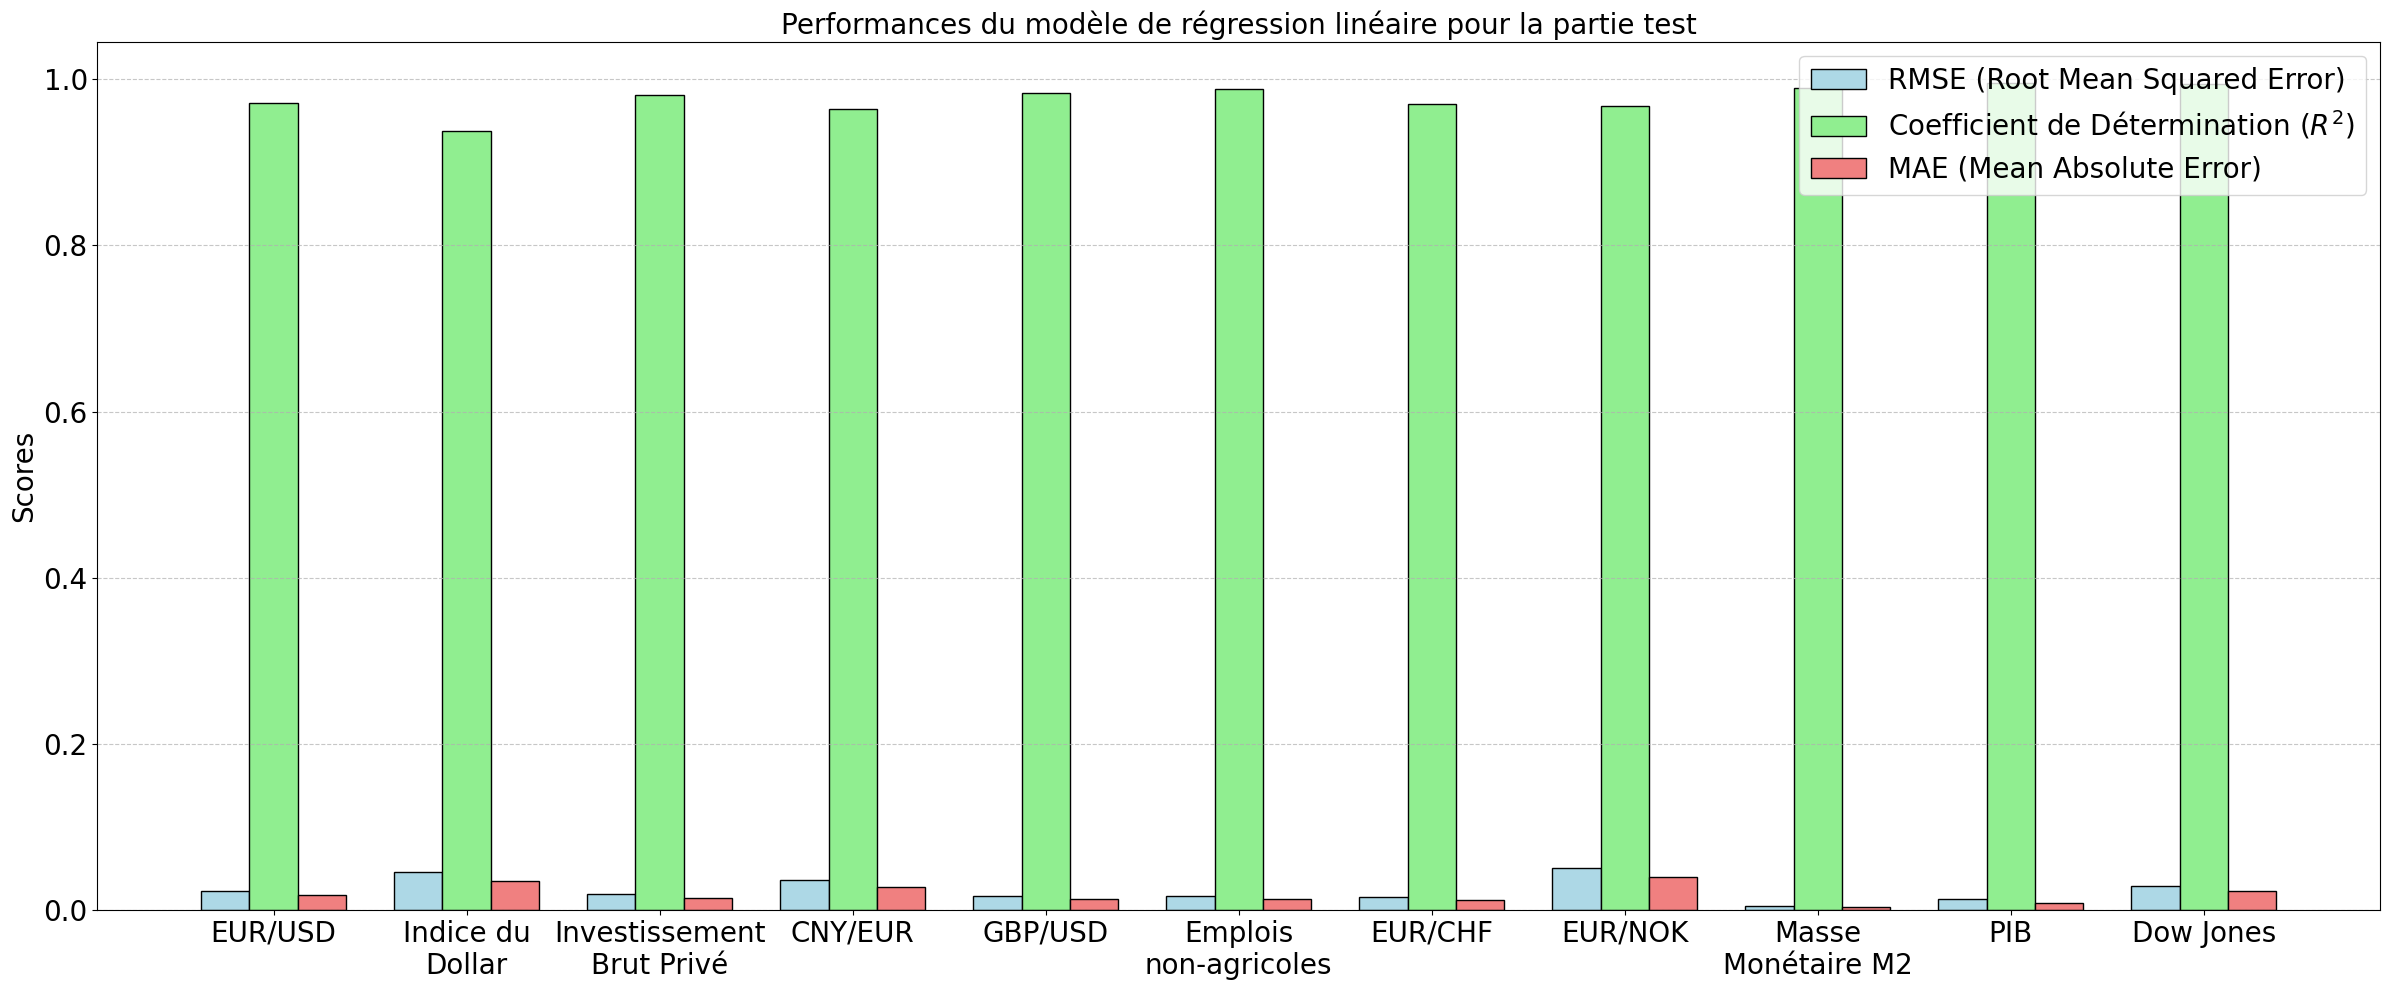

In [19]:

# ==============================================================================
# 1. DICTIONNAIRE DE TRADUCTION AVEC LABELS COURTS
# ==============================================================================
short_ticker_to_name_map = {
    # Devises et Indices utilisés dans le graphique
    'EUR/USD': 'EUR/USD',
    'DX-/Y.NYB': "Indice du\nDollar",
    'GPDIC1': "Investissement\nBrut Privé", # Abréviation
    'CNY/EUR': "CNY/EUR",
    'GBP/USD': 'GBP/USD',
    'PAYEMS': "Emplois\nnon-agricoles", # Formel mais plus court
    'EUR/CHF': 'EUR/CHF',
    'EUR/NOK': 'EUR/NOK',
    'M2SL': "Masse\nMonétaire M2",
    'GDP': "PIB", # Acronyme standard
    '^DJ/I': "Dow Jones", # Nom raccourci
}

# ==============================================================================
# 2. VOS DONNÉES (AUCUN CHANGEMENT ICI)
# ==============================================================================
# Liste des scores pour tous les indicateurs
rmse_scores = [np.sqrt(mse_retail_sales), np.sqrt(mse_Inflation), np.sqrt(mse_GDP), rmse_GPDIC1,
               rmse_indicator4, rmse_indicator5, rmse_indicator6, rmse_indicator7,
               rmse_indicator8, rmse_indicator9, rmse_indicator10]

r2_scores = [r2_retail_sales, r2_Inflation, r2_GDP, r2_GPDIC1,
             r2_indicator4, r2_indicator5, r2_indicator6, r2_indicator7,
             r2_indicator8, r2_indicator9, r2_indicator10]

mae_scores = [mae_retail_sales, mae_Inflation, mae_GDP, mae_GPDIC1,
              mae_indicator4, mae_indicator5, mae_indicator6, mae_indicator7,
              mae_indicator8, mae_indicator9, mae_indicator10]

# Liste des noms des modèles (ajustée pour inclure tous les indicateurs)
models = [chosen_currency, first_indicator, second_indicator, third_indicator,
          fourth_indicator, fifth_indicator, sixth_indicator, seventh_indicator,
          eighth_indicator, ninth_indicator, tenth_indicator]

# ==============================================================================
# 3. CODE DU GRAPHIQUE (AVEC LABELS DE LÉGENDE CORRIGÉS)
# ==============================================================================

# Largeur de chaque barre
bar_width = 0.25
index = np.arange(len(models))

# Création du graphe
plt.figure(figsize=(24, 10))

# === MODIFICATIONS CI-DESSOUS ===

# Plot des barres avec les labels de métriques formels
plt.bar(index - bar_width, rmse_scores, bar_width, label='RMSE (Root Mean Squared Error)', color='lightblue', edgecolor='black')
# Utilisation de la notation LaTeX pour un affichage propre de R²
plt.bar(index, r2_scores, bar_width, label=r'Coefficient de Détermination ($R^2$)', color='lightgreen', edgecolor='black')
plt.bar(index + bar_width, mae_scores, bar_width, label='MAE (Mean Absolute Error)', color='lightcoral', edgecolor='black')

# === FIN DES MODIFICATIONS ===

# Traduire les tickers en utilisant le dictionnaire de noms courts
translated_labels = [short_ticker_to_name_map.get(model, model) for model in models]

# Personnalisation des axes avec les labels courts et horizontaux
plt.ylabel('Scores', fontsize=20)
plt.title('Performances du modèle de régression linéaire pour la partie test', fontsize=20)
plt.xticks(index, translated_labels, fontsize=20, rotation=0, ha='center')
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

# Ajout de la grille
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustement des marges
plt.tight_layout()

# Affichage du graphe
plt.show()

In [21]:
# Nombre total de prédictions de test
len_test = len(y_test_GDP)

# Sélectionner les dates correspondant aux prédictions de test
dates_test = pmi_data_nv['Date'][-len_test:]

# Si vous voulez un échantillonnage toutes les 10 dates (ou un autre intervalle), vous pouvez utiliser ceci :
first_dates_test = dates_test[::len_test//20]

start_date = first_dates_test.iloc[0]
pmi_data_test = pmi_data_nv[pmi_data_nv['Date'] >= start_date]
pmi_data_test.reset_index(drop=True, inplace=True)

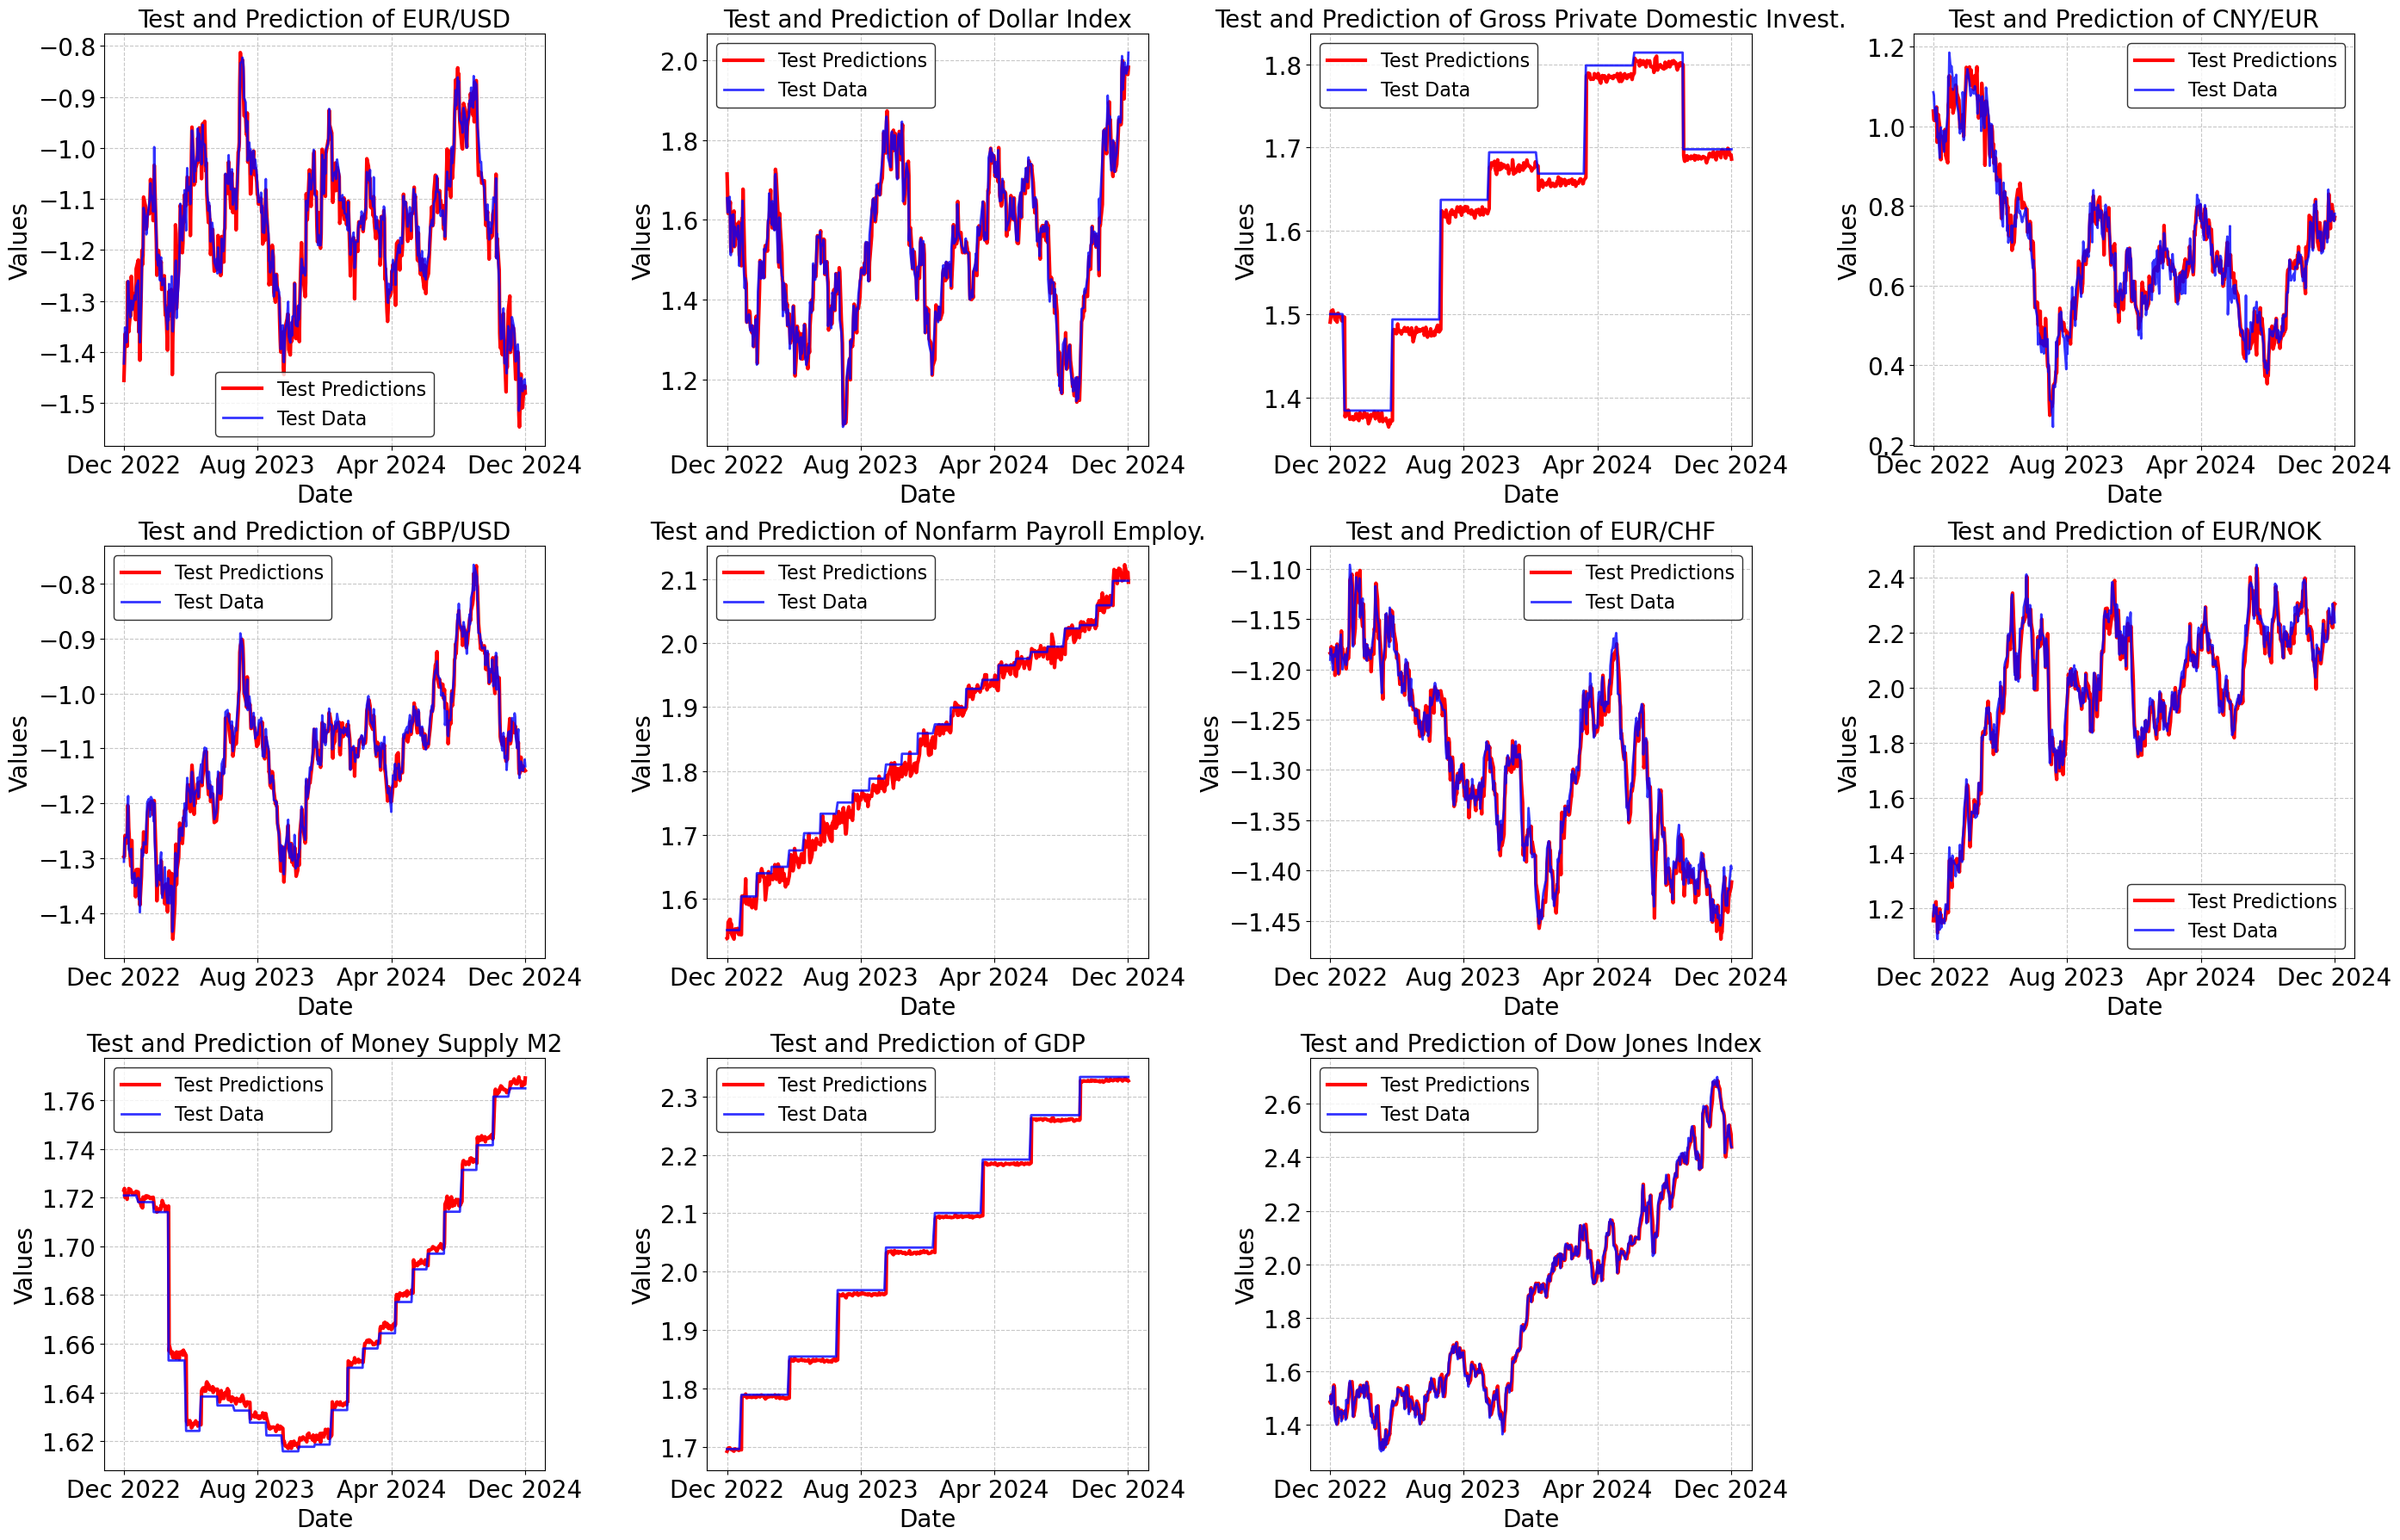

In [23]:
# Liste de tous les indicateurs avec leurs données et prédictions
indicators_data = [
    (chosen_currency, pmi_data_test[chosen_currency], y_pred_combined_retail_sales),
    (first_indicator, pmi_data_test[first_indicator], y_pred_combined_Inflation),
    (second_indicator, pmi_data_test[second_indicator], y_pred_combined_GDP),
    (third_indicator, pmi_data_test[third_indicator], y_pred_combined_GPDIC1),
    (fourth_indicator, pmi_data_test[fourth_indicator], y_pred_combined_indicator4),
    (fifth_indicator, pmi_data_test[fifth_indicator], y_pred_combined_indicator5),
    (sixth_indicator, pmi_data_test[sixth_indicator], y_pred_combined_indicator6),
    (seventh_indicator, pmi_data_test[seventh_indicator], y_pred_combined_indicator7),
    (eighth_indicator, pmi_data_test[eighth_indicator], y_pred_combined_indicator8),
    (ninth_indicator, pmi_data_test[ninth_indicator], y_pred_combined_indicator9),
    (tenth_indicator, pmi_data_test[tenth_indicator], y_pred_combined_indicator10)
]

# ==============================================================================
# 2. CONFIGURATION DE LA FIGURE ET DE LA GRILLE (Style du code précédent)
# ==============================================================================

# Définition de la grille de subplots
n_cols = 4
# Le nombre total d'indicateurs est 11
n_rows = (11 + n_cols - 1) // n_cols  # Calcul du nombre de lignes nécessaires

# Création de la figure globale avec les dimensions du code d'entraînement
plt.figure(figsize=(28, 6 * n_rows))


# ==============================================================================
# 3. TRACÉ MANUEL DE CHAQUE GRAPHIQUE DE TEST
# Chaque bloc applique le style du code d'entraînement aux données de test.
# ==============================================================================

# --- Graphique 1: chosen_currency ---
plt.subplot(n_rows, n_cols, 1)
# --- Plot 1: chosen_currency ---
# Apply style: predictions in red, actual data in blue
plt.plot(dates_test, y_pred_combined_retail_sales, label='Test Predictions', color='red', linestyle='-', linewidth=3)
plt.plot(dates_test, pmi_data_test[chosen_currency], label='Test Data', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Values', fontsize=20)
plt.title(f'Test and Prediction of EUR/USD', fontsize=20)
plt.legend(edgecolor='black', fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.tick_params(axis='x', labelsize=20)
sampled_dates_test = dates_test[::len(dates_test)//3]
ax.set_xticks(sampled_dates_test)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)

# --- Plot 2: first_indicator ---
plt.subplot(n_rows, n_cols, 2)
plt.plot(dates_test, y_pred_combined_Inflation, label='Test Predictions', color='red', linestyle='-', linewidth=3)
plt.plot(dates_test, pmi_data_test[first_indicator], label='Test Data', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Values', fontsize=20)
plt.title(f'Test and Prediction of Dollar Index', fontsize=20)
plt.legend(edgecolor='black', fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.tick_params(axis='x', labelsize=20)
sampled_dates_test = dates_test[::len(dates_test)//3]
ax.set_xticks(sampled_dates_test)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)

# --- Plot 3: second_indicator ---
plt.subplot(n_rows, n_cols, 3)
plt.plot(dates_test, y_pred_combined_GDP, label='Test Predictions', color='red', linestyle='-', linewidth=3)
plt.plot(dates_test, pmi_data_test[second_indicator], label='Test Data', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Values', fontsize=20)
plt.title(f'Test and Prediction of Gross Private Domestic Invest.', fontsize=20)
plt.legend(edgecolor='black', fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.tick_params(axis='x', labelsize=20)
sampled_dates_test = dates_test[::len(dates_test)//3]
ax.set_xticks(sampled_dates_test)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)

# --- Plot 4: third_indicator ---
plt.subplot(n_rows, n_cols, 4)
plt.plot(dates_test, y_pred_combined_GPDIC1, label='Test Predictions', color='red', linestyle='-', linewidth=3)
plt.plot(dates_test, pmi_data_test[third_indicator], label='Test Data', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Values', fontsize=20)
plt.title(f'Test and Prediction of {third_indicator}', fontsize=20)
plt.legend(edgecolor='black', fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.tick_params(axis='x', labelsize=20)
sampled_dates_test = dates_test[::len(dates_test)//3]
ax.set_xticks(sampled_dates_test)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)

# --- Plot 5: fourth_indicator ---
plt.subplot(n_rows, n_cols, 5)
plt.plot(dates_test, y_pred_combined_indicator4, label='Test Predictions', color='red', linestyle='-', linewidth=3)
plt.plot(dates_test, pmi_data_test[fourth_indicator], label='Test Data', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Values', fontsize=20)
plt.title(f'Test and Prediction of {fourth_indicator}', fontsize=20)
plt.legend(edgecolor='black', fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.tick_params(axis='x', labelsize=20)
sampled_dates_test = dates_test[::len(dates_test)//3]
ax.set_xticks(sampled_dates_test)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)

# --- Plot 6: fifth_indicator ---
plt.subplot(n_rows, n_cols, 6)
plt.plot(dates_test, y_pred_combined_indicator5, label='Test Predictions', color='red', linestyle='-', linewidth=3)
plt.plot(dates_test, pmi_data_test[fifth_indicator], label='Test Data', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Values', fontsize=20)
plt.title(f'Test and Prediction of Nonfarm Payroll Employ.', fontsize=20)
plt.legend(edgecolor='black', fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.tick_params(axis='x', labelsize=20)
sampled_dates_test = dates_test[::len(dates_test)//3]
ax.set_xticks(sampled_dates_test)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)

# --- Plot 7: sixth_indicator ---
plt.subplot(n_rows, n_cols, 7)
plt.plot(dates_test, y_pred_combined_indicator6, label='Test Predictions', color='red', linestyle='-', linewidth=3)
plt.plot(dates_test, pmi_data_test[sixth_indicator], label='Test Data', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Values', fontsize=20)
plt.title(f'Test and Prediction of {sixth_indicator}', fontsize=20)
plt.legend(edgecolor='black', fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.tick_params(axis='x', labelsize=20)
sampled_dates_test = dates_test[::len(dates_test)//3]
ax.set_xticks(sampled_dates_test)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)

# --- Plot 8: seventh_indicator ---
plt.subplot(n_rows, n_cols, 8)
plt.plot(dates_test, y_pred_combined_indicator7, label='Test Predictions', color='red', linestyle='-', linewidth=3)
plt.plot(dates_test, pmi_data_test[seventh_indicator], label='Test Data', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Values', fontsize=20)
plt.title(f'Test and Prediction of {seventh_indicator}', fontsize=20)
plt.legend(edgecolor='black', fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.tick_params(axis='x', labelsize=20)
sampled_dates_test = dates_test[::len(dates_test)//3]
ax.set_xticks(sampled_dates_test)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)

# --- Plot 9: eighth_indicator ---
plt.subplot(n_rows, n_cols, 9)
plt.plot(dates_test, y_pred_combined_indicator8, label='Test Predictions', color='red', linestyle='-', linewidth=3)
plt.plot(dates_test, pmi_data_test[eighth_indicator], label='Test Data', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Values', fontsize=20)
plt.title(f'Test and Prediction of Money Supply M2', fontsize=20)
plt.legend(edgecolor='black', fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.tick_params(axis='x', labelsize=20)
sampled_dates_test = dates_test[::len(dates_test)//3]
ax.set_xticks(sampled_dates_test)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)

# --- Plot 10: ninth_indicator ---
plt.subplot(n_rows, n_cols, 10)
plt.plot(dates_test, y_pred_combined_indicator9, label='Test Predictions', color='red', linestyle='-', linewidth=3)
plt.plot(dates_test, pmi_data_test[ninth_indicator], label='Test Data', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Values', fontsize=20)
plt.title(f'Test and Prediction of GDP', fontsize=20)
plt.legend(edgecolor='black', fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.tick_params(axis='x', labelsize=20)
sampled_dates_test = dates_test[::len(dates_test)//3]
ax.set_xticks(sampled_dates_test)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)

# --- Plot 11: tenth_indicator ---
plt.subplot(n_rows, n_cols, 11)
plt.plot(dates_test, y_pred_combined_indicator10, label='Test Predictions', color='red', linestyle='-', linewidth=3)
plt.plot(dates_test, pmi_data_test[tenth_indicator], label='Test Data', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Values', fontsize=20)
plt.title(f'Test and Prediction of Dow Jones Index', fontsize=20)
plt.legend(edgecolor='black', fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.tick_params(axis='x', labelsize=20)
sampled_dates_test = dates_test[::len(dates_test)//3]
ax.set_xticks(sampled_dates_test)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)


# ==============================================================================
# 4. FINALISATION
# ==============================================================================

# Masquer les subplots vides (le 12ème dans ce cas)
for j in range(11 + 1, n_rows * n_cols + 1):
    plt.subplot(n_rows, n_cols, j)
    plt.axis('off')

plt.tight_layout()

plt.show()


In [24]:

# --- Définition des dates (inchangée) ---
end_date = pmi_data['Date'].max()
end_date += timedelta(days=5)

def predict_future_values(model_retail_sales, model_Inflation, model_GDP, model_GPDIC1,
                         model_indicator4, model_indicator5, model_indicator6, model_indicator7,
                         model_indicator8, model_indicator9, model_indicator10,
                         start_date, end_date, pmi_data):
    # Générer les dates futures (uniquement les nouvelles dates)
    future_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Préparation des données pour la prédiction future (fenêtre glissante)
    past_data = pmi_data.iloc[-6:]

    past_retail_sales = past_data[chosen_currency].values.tolist()
    past_Inflation = past_data[first_indicator].values.tolist()
    past_GDP = past_data[second_indicator].values.tolist()
    past_GPDIC1 = past_data[third_indicator].values.tolist()
    past_indicator4 = past_data[fourth_indicator].values.tolist()
    past_indicator5 = past_data[fifth_indicator].values.tolist()
    past_indicator6 = past_data[sixth_indicator].values.tolist()
    past_indicator7 = past_data[seventh_indicator].values.tolist()
    past_indicator8 = past_data[eighth_indicator].values.tolist()
    past_indicator9 = past_data[ninth_indicator].values.tolist()
    past_indicator10 = past_data[tenth_indicator].values.tolist()

    # ============================ MODIFICATION CLÉ ============================
    # 1. Capturer la dernière ligne de données historiques
    last_historical_row = pmi_data.iloc[-1]
    last_historical_date = pmi_data['Date'].iloc[-1]

    # 2. Initialiser les listes de prédictions AVEC la dernière valeur historique
    # Cela assure que la première ligne du DataFrame final sera le dernier point connu.
    predictions = {
        chosen_currency: [last_historical_row[chosen_currency]],
        first_indicator: [last_historical_row[first_indicator]],
        second_indicator: [last_historical_row[second_indicator]],
        third_indicator: [last_historical_row[third_indicator]],
        fourth_indicator: [last_historical_row[fourth_indicator]],
        fifth_indicator: [last_historical_row[fifth_indicator]],
        sixth_indicator: [last_historical_row[sixth_indicator]],
        seventh_indicator: [last_historical_row[seventh_indicator]],
        eighth_indicator: [last_historical_row[eighth_indicator]],
        ninth_indicator: [last_historical_row[ninth_indicator]],
        tenth_indicator: [last_historical_row[tenth_indicator]]
    }
    # ========================= FIN DE LA MODIFICATION =========================

    for date in future_dates:
        # Prédictions pour chaque indicateur (logique inchangée)
        future_pred_retail_sales = model_retail_sales.predict(np.concatenate((
            past_retail_sales, past_Inflation, past_GDP, past_GPDIC1,
            past_indicator4, past_indicator5, past_indicator6, past_indicator7,
            past_indicator8, past_indicator9, past_indicator10)).reshape(1, -1))

        # ... (toutes les autres prédictions restent identiques) ...
        future_pred_Inflation = model_Inflation.predict(np.concatenate((past_Inflation, past_retail_sales, past_GDP, past_GPDIC1, past_indicator4, past_indicator5, past_indicator6, past_indicator7, past_indicator8, past_indicator9, past_indicator10)).reshape(1, -1))
        future_pred_GDP = model_GDP.predict(np.concatenate((past_GDP, past_retail_sales, past_Inflation, past_GPDIC1, past_indicator4, past_indicator5, past_indicator6, past_indicator7, past_indicator8, past_indicator9, past_indicator10)).reshape(1, -1))
        future_pred_GPDIC1 = model_GPDIC1.predict(np.concatenate((past_GPDIC1, past_retail_sales, past_Inflation, past_GDP, past_indicator4, past_indicator5, past_indicator6, past_indicator7, past_indicator8, past_indicator9, past_indicator10)).reshape(1, -1))
        future_pred_indicator4 = model_indicator4.predict(np.concatenate((past_indicator4, past_retail_sales, past_Inflation, past_GDP, past_GPDIC1, past_indicator5, past_indicator6, past_indicator7, past_indicator8, past_indicator9, past_indicator10)).reshape(1, -1))
        future_pred_indicator5 = model_indicator5.predict(np.concatenate((past_indicator5, past_retail_sales, past_Inflation, past_GDP, past_GPDIC1, past_indicator4, past_indicator6, past_indicator7, past_indicator8, past_indicator9, past_indicator10)).reshape(1, -1))
        future_pred_indicator6 = model_indicator6.predict(np.concatenate((past_indicator6, past_retail_sales, past_Inflation, past_GDP, past_GPDIC1, past_indicator4, past_indicator5, past_indicator7, past_indicator8, past_indicator9, past_indicator10)).reshape(1, -1))
        future_pred_indicator7 = model_indicator7.predict(np.concatenate((past_indicator7, past_retail_sales, past_Inflation, past_GDP, past_GPDIC1, past_indicator4, past_indicator5, past_indicator6, past_indicator8, past_indicator9, past_indicator10)).reshape(1, -1))
        future_pred_indicator8 = model_indicator8.predict(np.concatenate((past_indicator8, past_retail_sales, past_Inflation, past_GDP, past_GPDIC1, past_indicator4, past_indicator5, past_indicator6, past_indicator7, past_indicator9, past_indicator10)).reshape(1, -1))
        future_pred_indicator9 = model_indicator9.predict(np.concatenate((past_indicator9, past_retail_sales, past_Inflation, past_GDP, past_GPDIC1, past_indicator4, past_indicator5, past_indicator6, past_indicator7, past_indicator8, past_indicator10)).reshape(1, -1))
        future_pred_indicator10 = model_indicator10.predict(np.concatenate((past_indicator10, past_retail_sales, past_Inflation, past_GDP, past_GPDIC1, past_indicator4, past_indicator5, past_indicator6, past_indicator7, past_indicator8, past_indicator9)).reshape(1, -1))


        # Stockage des prédictions (on ajoute à la suite des données historiques)
        predictions[chosen_currency].append(future_pred_retail_sales[0])
        predictions[first_indicator].append(future_pred_Inflation[0])
        predictions[second_indicator].append(future_pred_GDP[0])
        predictions[third_indicator].append(future_pred_GPDIC1[0])
        predictions[fourth_indicator].append(future_pred_indicator4[0])
        predictions[fifth_indicator].append(future_pred_indicator5[0])
        predictions[sixth_indicator].append(future_pred_indicator6[0])
        predictions[seventh_indicator].append(future_pred_indicator7[0])
        predictions[eighth_indicator].append(future_pred_indicator8[0])
        predictions[ninth_indicator].append(future_pred_indicator9[0])
        predictions[tenth_indicator].append(future_pred_indicator10[0])

        # Mise à jour des données historiques pour la prochaine itération (logique inchangée)
        past_retail_sales.pop(0); past_retail_sales.append(future_pred_retail_sales[0])
        past_Inflation.pop(0); past_Inflation.append(future_pred_Inflation[0])
        past_GDP.pop(0); past_GDP.append(future_pred_GDP[0])
        past_GPDIC1.pop(0); past_GPDIC1.append(future_pred_GPDIC1[0])
        past_indicator4.pop(0); past_indicator4.append(future_pred_indicator4[0])
        past_indicator5.pop(0); past_indicator5.append(future_pred_indicator5[0])
        past_indicator6.pop(0); past_indicator6.append(future_pred_indicator6[0])
        past_indicator7.pop(0); past_indicator7.append(future_pred_indicator7[0])
        past_indicator8.pop(0); past_indicator8.append(future_pred_indicator8[0])
        past_indicator9.pop(0); past_indicator9.append(future_pred_indicator9[0])
        past_indicator10.pop(0); past_indicator10.append(future_pred_indicator10[0])

    # ============================ MODIFICATION CLÉ ============================
    # 3. Création du DataFrame de résultats avec les dates combinées
    # L'index combine la dernière date historique et les nouvelles dates futures.
    combined_dates = [last_historical_date] + future_dates.tolist()

    future_df = pd.DataFrame(index=combined_dates, data=predictions)
    future_df.index.name = 'Date' # Nommer l'index
    # ========================= FIN DE LA MODIFICATION =========================

    return future_df

# --- Appel de la fonction et traitement post-prédiction (inchangé) ---

# Prédiction des valeurs futures
last_date = pmi_data['Date'].max()
start_date = last_date + pd.DateOffset(days=1)
# Note : la date de début n'a plus besoin d'être formatée en string ici
# start_date = start_date.strftime('%Y-%m-%d')
end_date = pd.to_datetime(end_date)

predicted_df = predict_future_values(
    model_retail_sales, model_Inflation, model_GDP, model_GPDIC1,
    model_indicator4, model_indicator5, model_indicator6, model_indicator7,
    model_indicator8, model_indicator9, model_indicator10,
    start_date, end_date, pmi_data
)

# ... (le reste de votre code pour la dénormalisation reste identique) ...

columns_to_normalize = [
    chosen_currency, first_indicator, second_indicator, third_indicator,
    fourth_indicator, fifth_indicator, sixth_indicator, seventh_indicator,
    eighth_indicator, ninth_indicator, tenth_indicator
]

if hasattr(scaler, 'n_features_in_') and scaler.n_features_in_ != len(columns_to_normalize):
    from sklearn.preprocessing import StandardScaler
    all_columns = [chosen_currency, first_indicator, second_indicator, third_indicator,
                   fourth_indicator, fifth_indicator, sixth_indicator, seventh_indicator,
                   eighth_indicator, ninth_indicator, tenth_indicator]
    scaler = StandardScaler()
    scaler.fit(pmi_data[all_columns])

predicted_df[columns_to_normalize] = scaler.inverse_transform(predicted_df[columns_to_normalize])

predicted_df

EUR/USD   DX-/Y.NYB       GPDIC1   CNY/EUR   GBP/USD  \
Date                                                                
2024-12-31  1.040615  108.489998  4315.564000  0.131643  1.254910   
2025-01-01  1.035113  108.387744  4307.857375  0.131846  1.250135   
2025-01-02  1.036038  108.308104  4304.818162  0.131595  1.250253   
2025-01-03  1.037761  108.213043  4302.973295  0.131368  1.250816   
2025-01-04  1.038283  108.159022  4297.788719  0.131273  1.250652   
2025-01-05  1.038914  108.101977  4291.917875  0.131170  1.250542   

                   PAYEMS   EUR/CHF    EUR/NOK          M2SL           GDP  \
Date                                                                         
2024-12-31  158942.000000  0.939900  11.788110  21441.800000  29825.182000   
2025-01-01  158967.989032  0.937704  11.786820  21455.074943  29794.693314   
2025-01-02  159029.904053  0.936651  11.794117  21470.322601  29770.811826   
2025-01-03  159171.984471  0.937176  11.803800  21479.029415  29750.109245   
2025-01-04  159163.950437  0.936288  11.810766  21495.522535  29721.006481   
2025-01-05  159163.221272  0.935353  11.809312  21510.383806  29691.634747   

                   ^DJ/I  
Date                      
2024-12-31  42544.218750  
2025-01-01  42486.191921  
2025-01-02  42459.402586  
2025-01-03  42432.795343  
2025-01-04  42356.322466  
2025-01-05  42326.579876

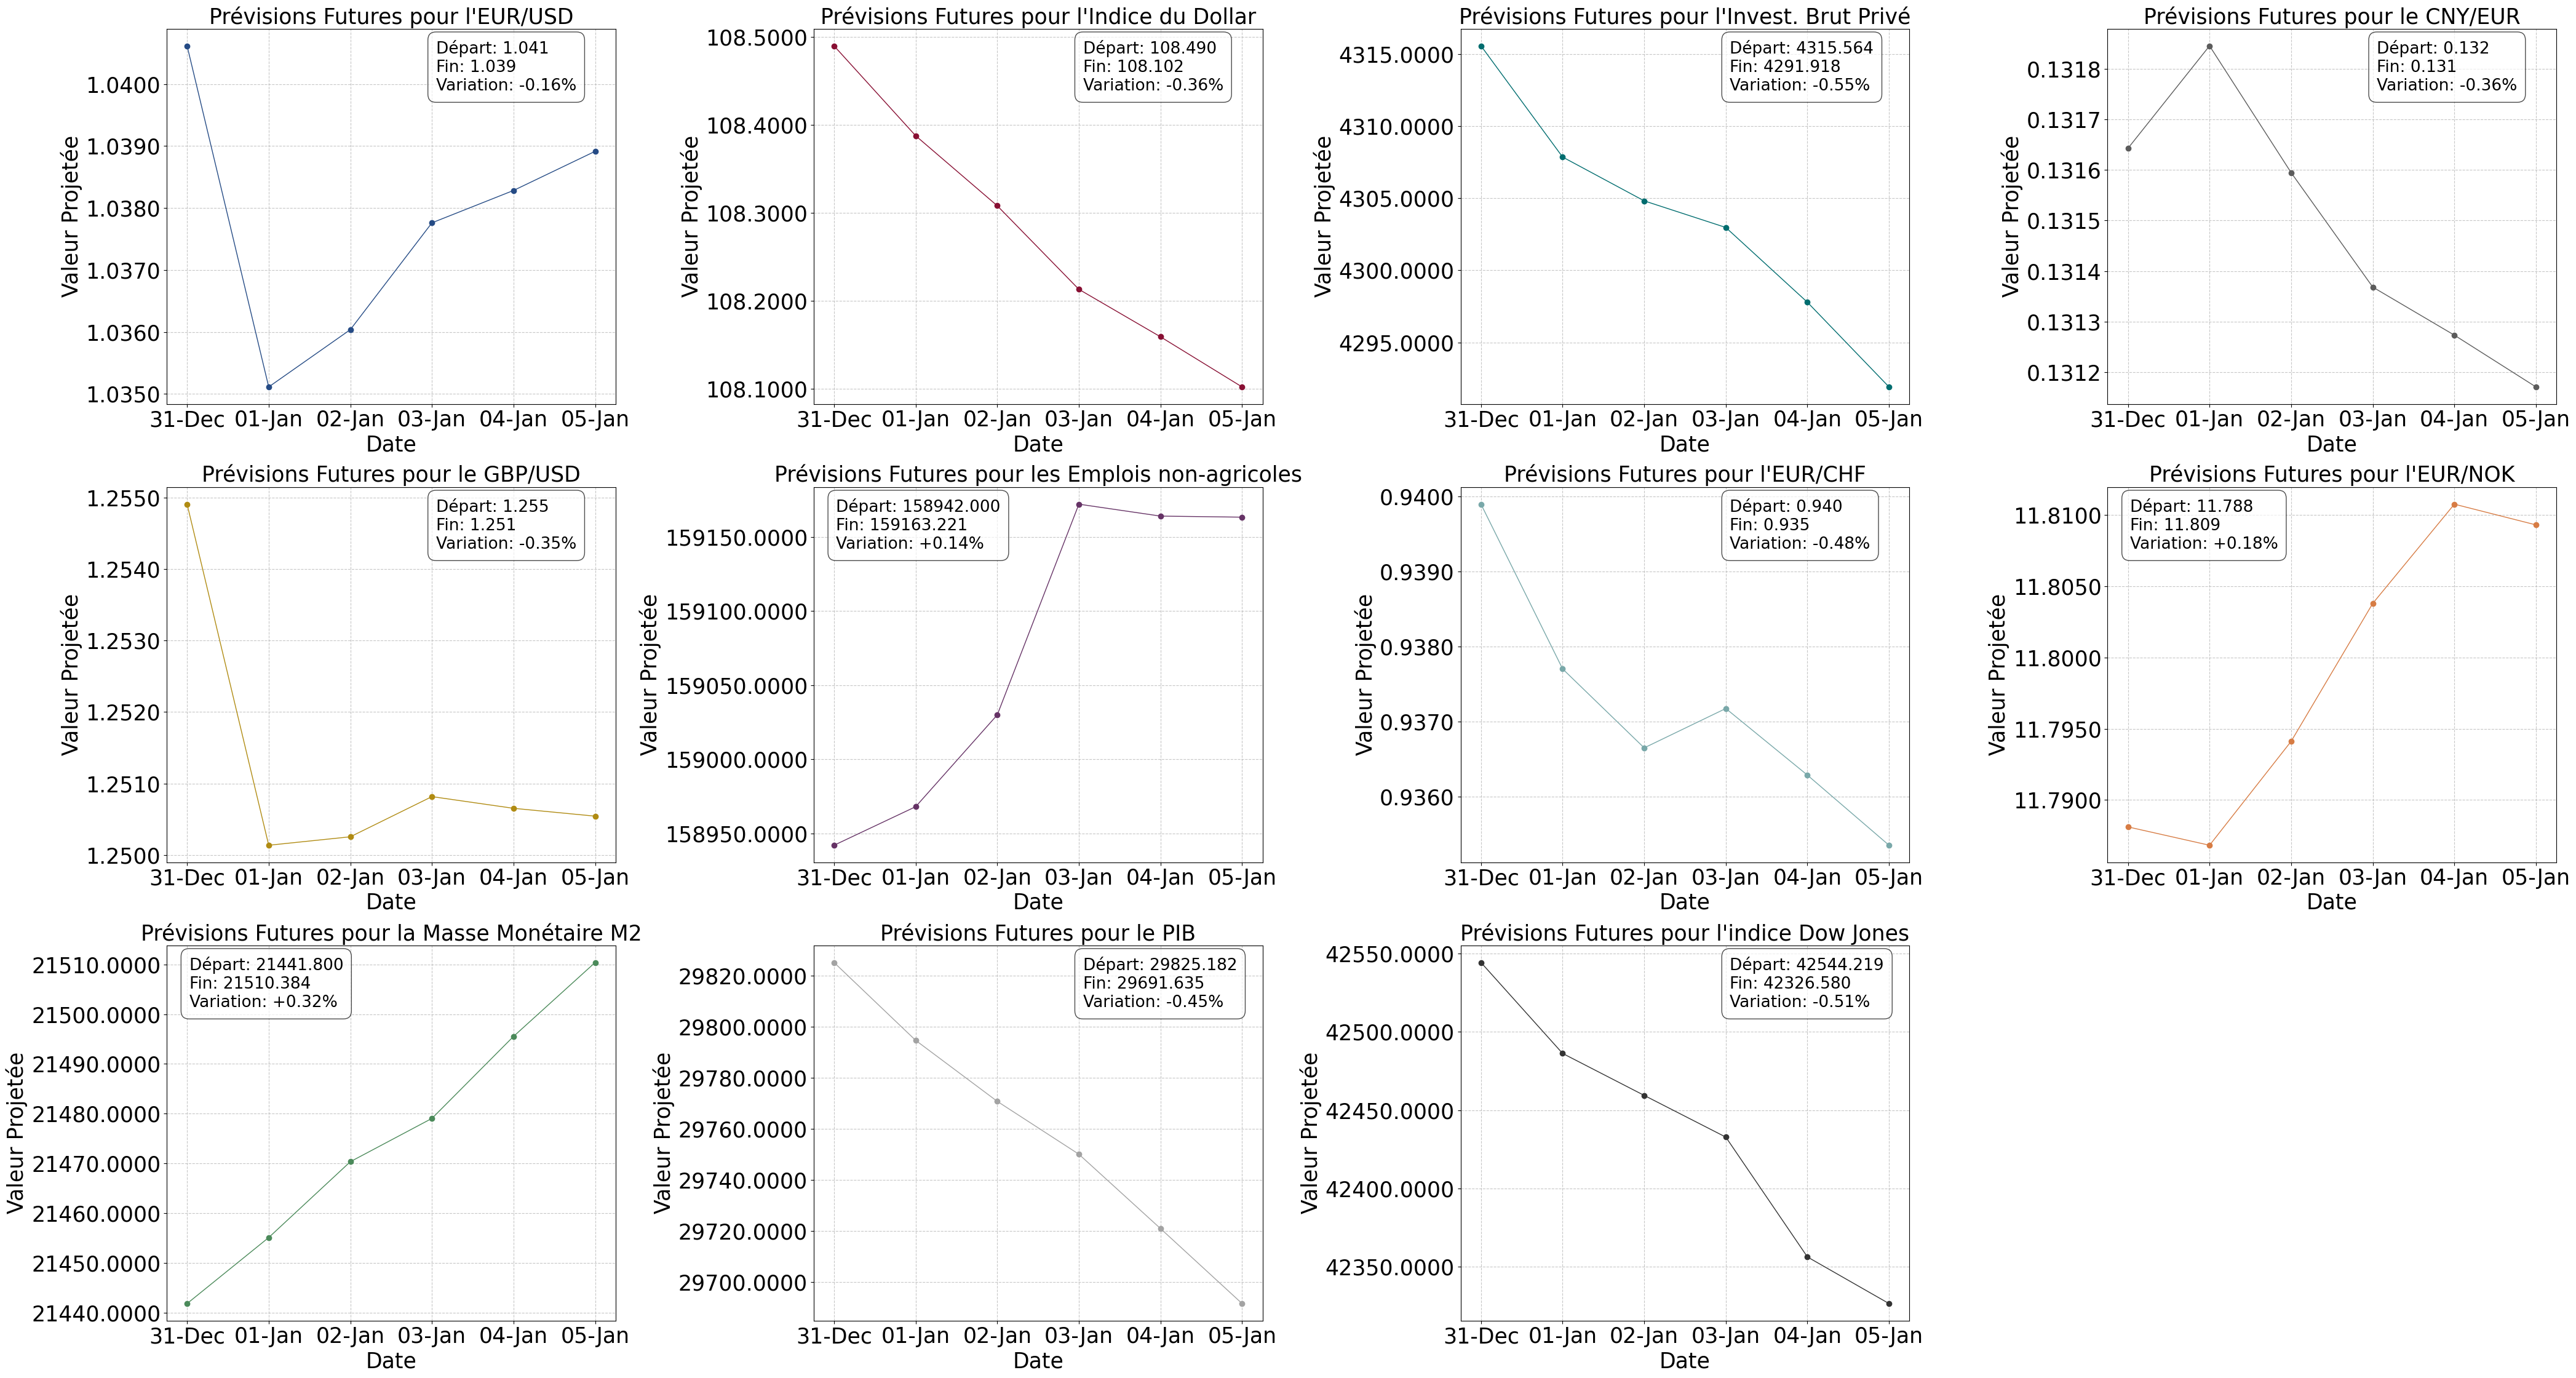

In [26]:

# ==============================================================================
# 1. CONFIGURATION ET PRÉPARATION
# ==============================================================================

# Liste des détails pour chaque indicateur, pour faciliter la réplication manuelle.
# J'utilise les noms clairs des titres précédents pour une cohérence maximale.
# Palette "Académique & Distinguée"
indicator_details = [
    # Couleurs principales sobres
    (chosen_currency, '#254b85', 'l\'EUR/USD'),             # Bleu marine profond
    (first_indicator, '#880f33', 'l\'Indice du Dollar'),      # Rouge vin
    (second_indicator, '#006d6f', 'l\'Invest. Brut Privé'),    # Vert-bleu foncé
    (third_indicator, '#5c5c5c', 'le CNY/EUR'),                  # Gris graphite
    # Couleurs secondaires douces
    (fourth_indicator, '#b08b12', f'le {fourth_indicator}'), # Vieil or
    (fifth_indicator, '#663366', 'les Emplois non-agricoles'),# Prune/Aubergine
    (sixth_indicator, '#79a8a9', f'l\'{sixth_indicator}'),   # Bleu-gris clair
    (seventh_indicator, '#d77c44', f'l\'{seventh_indicator}'), # Orange terre cuite
    (eighth_indicator, '#4b8a5a', 'la Masse Monétaire M2'),   # Vert forêt
    (ninth_indicator, '#a3a3a3', f'le PIB'),     # Gris clair
    (tenth_indicator, '#333333', 'l\'indice Dow Jones')      # Presque noir
]

# Définition de la grille de subplots
n_cols = 4
# Le nombre total d'indicateurs est 11
n_rows = (11 + n_cols - 1) // n_cols  # Calcul du nombre de lignes nécessaires

# Création de la figure globale avec les dimensions du code d'entraînement
plt.figure(figsize=(42, 7.5 * n_rows))


x=25
y=19

# ==============================================================================
# 2. TRACÉ MANUEL DE CHAQUE GRAPHIQUE DE PRÉDICTION
# Chaque bloc applique le style thèse au tracé des prédictions futures.
# ==============================================================================

# --- Graphique 1 ---
indicator_name, color, title_name = indicator_details[0]
ax1 = plt.subplot(n_rows, n_cols, 1)
ax1.plot(predicted_df.index, predicted_df[indicator_name], label=f'Prévisions', color=color, linestyle='-', marker='o', linewidth=1)
ax1.set_xlabel('Date', fontsize=x)
ax1.set_ylabel('Valeur Projetée', fontsize=x)
ax1.set_title(f'Prévisions Futures pour {title_name}', fontsize=x)
ax1.tick_params(axis='y', labelsize=x)
ax1.yaxis.set_major_formatter(plt.FormatStrFormatter('%.4f'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=0, ha='center', fontsize=x)
plt.yticks(fontsize=x)
ax1.grid(axis='both', linestyle='--', alpha=0.7)
# Annotation de performance
start_val = predicted_df[indicator_name].iloc[0]
end_val = predicted_df[indicator_name].iloc[-1]
if np.allclose(start_val, 0): # Gestion de la division par zéro
    pct_change_text = "N/A"
else:
    pct_change = ((end_val - start_val) / start_val) * 100
    pct_change_text = f'{pct_change:+.2f}%'
ax1.text(0.6, 0.97, f'Départ: {start_val:.3f}\nFin: {end_val:.3f}\nVariation: {pct_change_text}',
         transform=ax1.transAxes, fontsize=y, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))



# --- Graphique 2 ---
indicator_name, color, title_name = indicator_details[1]
ax2 = plt.subplot(n_rows, n_cols, 2)
ax2.plot(predicted_df.index, predicted_df[indicator_name], label=f'Prévisions',
         color=color, linestyle='-', marker='o', linewidth=1)
ax2.set_xlabel('Date', fontsize=x)
ax2.set_ylabel('Valeur Projetée', fontsize=x)  # cohérence avec Graphique 1
ax2.set_title(f'Prévisions Futures pour {title_name}', fontsize=x)
ax2.tick_params(axis='y', labelsize=x)
ax2.yaxis.set_major_formatter(plt.FormatStrFormatter('%.4f'))
ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=0, ha='center', fontsize=x)
plt.yticks(fontsize=x)
ax2.grid(axis='both', linestyle='--', alpha=0.7)
start_val = predicted_df[indicator_name].iloc[0]
end_val = predicted_df[indicator_name].iloc[-1]
if np.allclose(start_val, 0):
    pct_change_text = "N/A"
else:
    pct_change = ((end_val - start_val) / start_val) * 100
    pct_change_text = f'{pct_change:+.2f}%'
ax2.text(0.6, 0.97,
         f'Départ: {start_val:.3f}\nFin: {end_val:.3f}\nVariation: {pct_change_text}',
         transform=ax2.transAxes, fontsize=y, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))


# --- Graphique 3 ---
indicator_name, color, title_name = indicator_details[2]
ax3 = plt.subplot(n_rows, n_cols, 3)
ax3.plot(predicted_df.index, predicted_df[indicator_name], label=f'Prévisions',
         color=color, linestyle='-', marker='o', linewidth=1)
ax3.set_xlabel('Date', fontsize=x)
ax3.set_ylabel('Valeur Projetée', fontsize=x)
ax3.set_title(f'Prévisions Futures pour {title_name}', fontsize=x)
ax3.tick_params(axis='y', labelsize=x)
ax3.yaxis.set_major_formatter(plt.FormatStrFormatter('%.4f'))
ax3.xaxis.set_major_locator(mdates.AutoDateLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=0, ha='center', fontsize=x)
plt.yticks(fontsize=x)
ax3.grid(axis='both', linestyle='--', alpha=0.7)
start_val = predicted_df[indicator_name].iloc[0]
end_val = predicted_df[indicator_name].iloc[-1]
if np.allclose(start_val, 0):
    pct_change_text = "N/A"
else:
    pct_change = ((end_val - start_val) / start_val) * 100
    pct_change_text = f'{pct_change:+.2f}%'
ax3.text(0.6, 0.97,
         f'Départ: {start_val:.3f}\nFin: {end_val:.3f}\nVariation: {pct_change_text}',
         transform=ax3.transAxes, fontsize=y, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))



# --- Graphique 4 ---
indicator_name, color, title_name = indicator_details[3]
ax4 = plt.subplot(n_rows, n_cols, 4)
ax4.plot(predicted_df.index, predicted_df[indicator_name], label=f'Prévisions',
         color=color, linestyle='-', marker='o', linewidth=1)
# Axes et titre avec fontsize = 22
ax4.set_xlabel('Date', fontsize=x)
ax4.set_ylabel('Valeur Projetée', fontsize=x)
ax4.set_title(f'Prévisions Futures pour {title_name}', fontsize=x)
# Ticks avec fontsize = 22
ax4.tick_params(axis='y', labelsize=x)
ax4.yaxis.set_major_formatter(plt.FormatStrFormatter('%.4f'))
ax4.xaxis.set_major_locator(mdates.AutoDateLocator())
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=0, ha='center', fontsize=x)
plt.yticks(fontsize=x)
# Grille
ax4.grid(axis='both', linestyle='--', alpha=0.7)
# Annotation (fontsize = 18)
start_val = predicted_df[indicator_name].iloc[0]
end_val = predicted_df[indicator_name].iloc[-1]
if np.allclose(start_val, 0):
    pct_change_text = "N/A"
else:
    pct_change = ((end_val - start_val) / start_val) * 100
    pct_change_text = f'{pct_change:+.2f}%'
ax4.text(0.6, 0.97,
         f'Départ: {start_val:.3f}\nFin: {end_val:.3f}\nVariation: {pct_change_text}',
         transform=ax4.transAxes, fontsize=y, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))



# --- Graphique 5 ---
indicator_name, color, title_name = indicator_details[4]
ax5 = plt.subplot(n_rows, n_cols, 5)
ax5.plot(predicted_df.index, predicted_df[indicator_name], label=f'Prévisions',
         color=color, linestyle='-', marker='o', linewidth=1)
# Axes et titre avec fontsize = 22
ax5.set_xlabel('Date', fontsize=x)
ax5.set_ylabel('Valeur Projetée', fontsize=x)
ax5.set_title(f'Prévisions Futures pour {title_name}', fontsize=x)
# Ticks avec fontsize = 22
ax5.tick_params(axis='y', labelsize=x)
ax5.yaxis.set_major_formatter(plt.FormatStrFormatter('%.4f'))
ax5.xaxis.set_major_locator(mdates.AutoDateLocator())
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=0, ha='center', fontsize=x)
plt.yticks(fontsize=x)
# Grille
ax5.grid(axis='both', linestyle='--', alpha=0.7)
# Annotation (fontsize = 18)
start_val = predicted_df[indicator_name].iloc[0]
end_val = predicted_df[indicator_name].iloc[-1]
if np.allclose(start_val, 0):
    pct_change_text = "N/A"
else:
    pct_change = ((end_val - start_val) / start_val) * 100
    pct_change_text = f'{pct_change:+.2f}%'
ax5.text(0.6, 0.97,
         f'Départ: {start_val:.3f}\nFin: {end_val:.3f}\nVariation: {pct_change_text}',
         transform=ax5.transAxes, fontsize=y, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))



# --- Graphique 6 ---
indicator_name, color, title_name = indicator_details[5]
ax6 = plt.subplot(n_rows, n_cols, 6)
ax6.plot(predicted_df.index, predicted_df[indicator_name], label=f'Prévisions',
         color=color, linestyle='-', marker='o', linewidth=1)
# Axes et titre avec fontsize = 22
ax6.set_xlabel('Date', fontsize=x)
ax6.set_ylabel('Valeur Projetée', fontsize=x)
ax6.set_title(f'Prévisions Futures pour {title_name}', fontsize=x)
# Ticks avec fontsize = 22
ax6.tick_params(axis='y', labelsize=x)
ax6.yaxis.set_major_formatter(plt.FormatStrFormatter('%.4f'))
ax6.xaxis.set_major_locator(mdates.AutoDateLocator())
ax6.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=0, ha='center', fontsize=x)
plt.yticks(fontsize=x)
# Grille
ax6.grid(axis='both', linestyle='--', alpha=0.7)
# Annotation (fontsize = 18)
start_val = predicted_df[indicator_name].iloc[0]
end_val = predicted_df[indicator_name].iloc[-1]
if np.allclose(start_val, 0):
    pct_change_text = "N/A"
else:
    pct_change = ((end_val - start_val) / start_val) * 100
    pct_change_text = f'{pct_change:+.2f}%'
ax6.text(0.05, 0.97,
         f'Départ: {start_val:.3f}\nFin: {end_val:.3f}\nVariation: {pct_change_text}',
         transform=ax6.transAxes, fontsize=y, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))



# --- Graphique 7 ---
indicator_name, color, title_name = indicator_details[6]
ax7 = plt.subplot(n_rows, n_cols, 7)
ax7.plot(predicted_df.index, predicted_df[indicator_name], label=f'Prévisions',
         color=color, linestyle='-', marker='o', linewidth=1)
# Axes et titre avec fontsize = 22
ax7.set_xlabel('Date', fontsize=x)
ax7.set_ylabel('Valeur Projetée', fontsize=x)
ax7.set_title(f'Prévisions Futures pour {title_name}', fontsize=x)
# Ticks avec fontsize = 22
ax7.tick_params(axis='y', labelsize=x)
ax7.yaxis.set_major_formatter(plt.FormatStrFormatter('%.4f'))
ax7.xaxis.set_major_locator(mdates.AutoDateLocator())
ax7.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=0, ha='center', fontsize=x)
plt.yticks(fontsize=x)
# Grille
ax7.grid(axis='both', linestyle='--', alpha=0.7)
# Annotation (fontsize = 18)
start_val = predicted_df[indicator_name].iloc[0]
end_val = predicted_df[indicator_name].iloc[-1]
if np.allclose(start_val, 0):
    pct_change_text = "N/A"
else:
    pct_change = ((end_val - start_val) / start_val) * 100
    pct_change_text = f'{pct_change:+.2f}%'
ax7.text(0.6, 0.97,
         f'Départ: {start_val:.3f}\nFin: {end_val:.3f}\nVariation: {pct_change_text}',
         transform=ax7.transAxes, fontsize=y, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))



# --- Graphique 8 ---
indicator_name, color, title_name = indicator_details[7]
ax8 = plt.subplot(n_rows, n_cols, 8)
ax8.plot(predicted_df.index, predicted_df[indicator_name], label=f'Prévisions',
         color=color, linestyle='-', marker='o', linewidth=1)
# Axes et titre avec fontsize = 22
ax8.set_xlabel('Date', fontsize=x)
ax8.set_ylabel('Valeur Projetée', fontsize=x)
ax8.set_title(f'Prévisions Futures pour {title_name}', fontsize=x)
# Ticks avec fontsize = 22
ax8.tick_params(axis='y', labelsize=x)
ax8.yaxis.set_major_formatter(plt.FormatStrFormatter('%.4f'))
ax8.xaxis.set_major_locator(mdates.AutoDateLocator())
ax8.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=0, ha='center', fontsize=x)
plt.yticks(fontsize=x)
# Grille
ax8.grid(axis='both', linestyle='--', alpha=0.7)
# Annotation (fontsize = 18)
start_val = predicted_df[indicator_name].iloc[0]
end_val = predicted_df[indicator_name].iloc[-1]
if np.allclose(start_val, 0):
    pct_change_text = "N/A"
else:
    pct_change = ((end_val - start_val) / start_val) * 100
    pct_change_text = f'{pct_change:+.2f}%'
ax8.text(0.05, 0.97,
         f'Départ: {start_val:.3f}\nFin: {end_val:.3f}\nVariation: {pct_change_text}',
         transform=ax8.transAxes, fontsize=y, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))



# --- Graphique 9 ---
indicator_name, color, title_name = indicator_details[8]
ax9 = plt.subplot(n_rows, n_cols, 9)
ax9.plot(predicted_df.index, predicted_df[indicator_name], label=f'Prévisions',
         color=color, linestyle='-', marker='o', linewidth=1)
# Axes et titre avec fontsize = 22
ax9.set_xlabel('Date', fontsize=x)
ax9.set_ylabel('Valeur Projetée', fontsize=x)
ax9.set_title(f'Prévisions Futures pour {title_name}', fontsize=x)
# Ticks avec fontsize = 22
ax9.tick_params(axis='y', labelsize=x)
ax9.yaxis.set_major_formatter(plt.FormatStrFormatter('%.4f'))
ax9.xaxis.set_major_locator(mdates.AutoDateLocator())
ax9.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=0, ha='center', fontsize=x)
plt.yticks(fontsize=x)
# Grille
ax9.grid(axis='both', linestyle='--', alpha=0.7)
# Annotation (fontsize = 18)
start_val = predicted_df[indicator_name].iloc[0]
end_val = predicted_df[indicator_name].iloc[-1]
if np.allclose(start_val, 0):
    pct_change_text = "N/A"
else:
    pct_change = ((end_val - start_val) / start_val) * 100
    pct_change_text = f'{pct_change:+.2f}%'
ax9.text(0.05, 0.97,
         f'Départ: {start_val:.3f}\nFin: {end_val:.3f}\nVariation: {pct_change_text}',
         transform=ax9.transAxes, fontsize=y, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))



# --- Graphique 10 ---
indicator_name, color, title_name = indicator_details[9]
ax10 = plt.subplot(n_rows, n_cols, 10)
ax10.plot(predicted_df.index, predicted_df[indicator_name], label=f'Prévisions',
          color=color, linestyle='-', marker='o', linewidth=1)
# Axes et titre avec fontsize = 22
ax10.set_xlabel('Date', fontsize=x)
ax10.set_ylabel('Valeur Projetée', fontsize=x)
ax10.set_title(f'Prévisions Futures pour {title_name}', fontsize=x)
# Ticks avec fontsize = 22
ax10.tick_params(axis='y', labelsize=x)
ax10.yaxis.set_major_formatter(plt.FormatStrFormatter('%.4f'))
ax10.xaxis.set_major_locator(mdates.AutoDateLocator())
ax10.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=0, ha='center', fontsize=x)
plt.yticks(fontsize=x)
# Grille
ax10.grid(axis='both', linestyle='--', alpha=0.7)
# Annotation (fontsize = 18)
start_val = predicted_df[indicator_name].iloc[0]
end_val = predicted_df[indicator_name].iloc[-1]
if np.allclose(start_val, 0):
    pct_change_text = "N/A"
else:
    pct_change = ((end_val - start_val) / start_val) * 100
    pct_change_text = f'{pct_change:+.2f}%'
ax10.text(0.6, 0.97,
          f'Départ: {start_val:.3f}\nFin: {end_val:.3f}\nVariation: {pct_change_text}',
          transform=ax10.transAxes, fontsize=y, verticalalignment='top',
          bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))



# --- Graphique 11 ---
indicator_name, color, title_name = indicator_details[10]
ax11 = plt.subplot(n_rows, n_cols, 11)
ax11.plot(predicted_df.index, predicted_df[indicator_name], label=f'Prévisions',
          color=color, linestyle='-', marker='o', linewidth=1)
# Axes et titre avec fontsize = 22
ax11.set_xlabel('Date', fontsize=x)
ax11.set_ylabel('Valeur Projetée', fontsize=x)
ax11.set_title(f'Prévisions Futures pour {title_name}', fontsize=x)
# Ticks avec fontsize = 22
ax11.tick_params(axis='y', labelsize=x)
ax11.yaxis.set_major_formatter(plt.FormatStrFormatter('%.4f'))
ax11.xaxis.set_major_locator(mdates.AutoDateLocator())
ax11.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=0, ha='center', fontsize=x)
plt.yticks(fontsize=x)
# Grille
ax11.grid(axis='both', linestyle='--', alpha=0.7)
# Annotation (fontsize = 18)
start_val = predicted_df[indicator_name].iloc[0]
end_val = predicted_df[indicator_name].iloc[-1]
if np.allclose(start_val, 0):
    pct_change_text = "N/A"
else:
    pct_change = ((end_val - start_val) / start_val) * 100
    pct_change_text = f'{pct_change:+.2f}%'
ax11.text(0.6, 0.97,
          f'Départ: {start_val:.3f}\nFin: {end_val:.3f}\nVariation: {pct_change_text}',
          transform=ax11.transAxes, fontsize=y, verticalalignment='top',
          bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))



# ==============================================================================
# 3. FINALISATION
# ==============================================================================

# Masquer les subplots vides
for j in range(len(indicator_details), n_rows * n_cols):
    plt.subplot(n_rows, n_cols, j + 1)
    plt.axis('off')

# Ajustement final
plt.tight_layout()
plt.show()
